# **Declaration**
This is the **final** submission.

All data used in this file are from https://data.gov.hk/en/ and HKT Limited, which are provided and authorized by the organizers of IOT Data Hackathon 2025.

This file is a **simulation** of our solution, **AirSmart**, which is the **combination** of **weather prediction and model predictve control in HVAC system**. Here, we demonstrate the **smart temperature control.**


In [ ]:
# import necessary libraries
from google.colab import drive
import pandas as pd
import time
from matplotlib import pyplot as plt
import numpy as np
import torch
from torch import nn
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import os
from datetime import datetime, timedelta
import gym
import random
import torch.nn.functional as F
from collections import deque
from torch.distributions import Categorical
from torch.optim.lr_scheduler import CosineAnnealingLR
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
import pickle

In [ ]:
drive.mount("/content/drive")

In [ ]:
# variable list
place = "HKA"
path = "" # path you store the data
place_full = "Hong Kong International Airport"
invalid = "***"
lookback = 7

The weather prediction model is trained based on the  temperature, humidity, wind speed, and mean pressure data of Hong Kong International Airport from June 1997 to November 2024, while the AC model is trained based on the dataset provided by the **HKT Limited**.

Source:
https://data.gov.hk/en-data/dataset/hk-hko-rss-daily-temperature-info-hko
https://data.gov.hk/en-data/dataset/hk-hko-rss-daily-mean-wind-speed
https://data.gov.hk/en-data/dataset/hk-hko-rss-daily-mean-relative-humidity
https://data.gov.hk/en-data/dataset/hk-hko-rss-daily-mean-pressure

# **First Glance of AirSmart**
Run the following cell and have fun!

In [6]:
%pip install pyngrok

Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for pyngrok from https://files.pythonhosted.org/packages/b1/18/b04c16630a55072df02c55419fde1bd3acd101f56add62781d2a9ac94c5c/pyngrok-7.2.3-py3-none-any.whl.metadata
Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [7]:
from flask import Flask, request, render_template, redirect, url_for, session, jsonify
from pyngrok import ngrok
import numpy as np
import torch
import os
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from AirSmart.HVAC_Temperature_control import hvac_basic
from AirSmart.HVAC_Temperature_control.ac_model import AC_output
from AirSmart.weather_forecast import bilstm_model

app = Flask(__name__)

# mock user data
users = {
    'admin': '123'
}

@app.route('/')
def home():
    if 'username' in session:
        return render_template('monitor.html')
    else:
        return redirect(url_for('login'))

@app.route('/login', methods=['GET', 'POST'])
def login():
    if request.method == 'POST':
        username = request.form['username']
        password = request.form['password']
        print(username, password)
        
        if username in users and users[username] == password:
            session['username'] = username  # 将用户名存储在 session 中
            return redirect(url_for('monitor'))  # 修正为跳转到 monitor
        else:
            return "Invalid username or password"
    return render_template('login.html')

@app.route('/monitor', methods=['GET', 'POST'])
def monitor():
    if 'username' not in session:
        return redirect(url_for('login'))
    
    if request.method == 'POST':
        building = request.form.get('building')
        print(building)
        # load trained model from depository
        lstm_model = bilstm_model.LSTMModel()

        # load best scored
        best_model_weights_path = os.path.join(path, 'best_model_weights.pth')
        lstm_model.load_state_dict(torch.load(best_model_weights_path))

        # evaluation
        lstm_model.eval()

        # load other parameters
        params_path = os.path.join(path, 'training_params.pth')
        try:
            params = torch.load(params_path, weights_only=False)
        except Exception as e:
            print(f"Error loading params: {e}")
            return "Error loading model parameters", 500

        best_score = params['best_score']
        best_train_preds = params['best_train_preds']
        best_test_preds = params['best_test_preds']
        epochs = params['epochs']

        # process test data
        future_steps = 10
        test_ = pd.read_csv(path+"TEST_"+place+"_DATASET_.csv")
        test_ = test_.values.astype("float32")
        x_test = test_[-future_steps:,1:]
        scaler = MinMaxScaler()
        x_test = scaler.fit_transform(x_test)

        # make prediction
        pred_temp = bilstm_model.predict_future(lstm_model, x_test, future_steps)

        # undo scaling
        predicted_temps = scaler.inverse_transform(np.array(pred_temp))
        print(f"Temperature predictions of coming {future_steps} days:", predicted_temps[:,-1])

        hkt02 = pd.read_excel("C:\\test\\dataset_hkt\\hkt\\a002-1f-sr-tp01_timeseries.xlsx")
        hkt02temps = np.array(hkt02["temperature"].astype(float))
        hkt02temps = hkt02temps[5000:5010]
        hkt02temps = hkt02temps[:,None]
        ptemp = predicted_temps[:,-1]
        ptemp = ptemp[:,None]
        predicted_temps = np.concatenate((hkt02temps, ptemp), axis=1)

        # predict action of Air Conditioner
        ACMPC = AC_output(model_path=path+"ac_model_test_hkt.pth")
        energy = hvac_basic.energy_consume(ACMPC.predict(predicted_temps), predicted_temps[-1][0], predicted_temps[-1][0])
        new_indoor = hvac_basic.indoor_temp_change(ACMPC.predict(predicted_temps), predicted_temps[-1][0], predicted_temps[-1][0])
        re_ac_temp = ACMPC.predict(predicted_temps)

        print(f"Current Indoor Temperature: {predicted_temps[-1][0]:.3f}°C\tOutdoor Temperature: {predicted_temps[-1][1]:.3f}°C")
        print(f"Recommend AC Temperature: {re_ac_temp}°C")
        print(f"New Indoor Temperature: {new_indoor:.3f}°C")
        print(f"Energy Consumption: {energy:.3f}kWh")

        # clean cache
        app.jinja_env.cache.clear()
        del lstm_model
        del ACMPC
        torch.cuda.empty_cache()
        import gc
        gc.collect()

        # send data to the server
        return jsonify({"currIn":predicted_temps[-1][0], "currOut":round(predicted_temps[-1][1],3),"newIndoor":round(new_indoor,3),"ACtemp":re_ac_temp,"energy":round(energy,3)}), 200
    else:
        return render_template('monitor.html')

@app.route('/logout')
def logout():
    session.pop('username', None)
    return redirect(url_for('login'))

if __name__ == '__main__':
    public_url = ngrok.connect(5000).public_url
    print(f" * Running on {public_url}")
    app.run(debug=True)

t=2025-03-22T12:34:41+0800 lvl=warn msg="can't bind default web address, trying alternatives" obj=web addr=127.0.0.1:4040
t=2025-03-22T12:34:44+0800 lvl=eror msg="failed to reconnect session" obj=tunnels.session err="authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your authtoken: https://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_4018\r\n"
t=2025-03-22T12:34:44+0800 lvl=eror msg="session closing" obj=tunnels.session err="authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your authtoken: https://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_4018\r\n"
t=2025-03-22T12:34:44+0800 lvl=eror msg="terminating with error" obj=app err="authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashbo

PyngrokNgrokError: The ngrok process errored on start: authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your authtoken: https://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_4018\r\n.

In [2]:
%td

UsageError: Line magic function `%td` not found.


# **Visualization of Original Data**

In [ ]:
# open the csv file
data = pd.read_csv(path+"CLMTEMP_"+place+"_.csv", on_bad_lines='skip')
maxt = pd.read_csv(path+"CLMMAXT_"+place+"_.csv", on_bad_lines='skip')
mint = pd.read_csv(path+"CLMMINT_"+place+"_.csv", on_bad_lines='skip')
wind = pd.read_csv(path+"daily_"+place+"_WSPD_ALL.csv", on_bad_lines='skip')
hum = pd.read_csv(path+"daily_"+place+"_RH_ALL.csv", on_bad_lines='skip')
pr = pd.read_csv(path+"daily_"+place+"_MSLP_ALL.csv", on_bad_lines='skip')

In [ ]:
# create dataframe
meandf = pd.DataFrame(data)
meandf.info()
maxdf = pd.DataFrame(maxt)
maxdf.info()
mindf = pd.DataFrame(mint)
mindf.info()
winddf = pd.DataFrame(wind)
winddf.info()
humdf = pd.DataFrame(hum)
humdf.info()
prdf = pd.DataFrame(pr)
prdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10045 entries, 0 to 10044
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Year               10045 non-null  int64  
 1   Month              10045 non-null  int64  
 2   Day                10045 non-null  int64  
 3   Value              10045 non-null  float64
 4   data Completeness  10045 non-null  object 
dtypes: float64(1), int64(3), object(1)
memory usage: 392.5+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10045 entries, 0 to 10044
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Year               10045 non-null  int64 
 1   Month              10045 non-null  int64 
 2   Day                10045 non-null  int64 
 3   Value              10045 non-null  object
 4   data Completeness  10045 non-null  object
dtypes: int64(3), object(2)
memory usage: 392.5+ KB
<cl

In [ ]:
# combine all csv files into 1
maxdf = maxdf.drop(columns=["data Completeness"])
mindf = mindf.drop(columns=["data Completeness"])
meandf = meandf.drop(columns=["data Completeness"])
# convert year, month and day columns into int
meandf["Year"] = meandf["Year"].astype(int)
meandf["Month"] = meandf["Month"].astype(int)
meandf["Day"] = meandf["Day"].astype(int)
# create a dataframe to collect all data
df = pd.DataFrame()
df["Date"] = meandf.apply(lambda row: f"{int(row['Year'])}-{int(row['Month'])}-{int(row['Day'])}", axis=1)
df["Date"] = pd.to_datetime(df["Date"])
df["Year"] = meandf["Year"]
df["Month"] = meandf["Month"]
df["Day"] = meandf["Day"]
df["Max Temp"] = maxdf["Value"]
df["Mean Temp"] = meandf["Value"]
df["Min Temp"] = mindf["Value"]
df["Humidity"] = humdf["Value"]
df["Wind Speed"] = winddf["Value"]
df["Mean Pressure"] = prdf["Value"]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10045 entries, 0 to 10044
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           10045 non-null  datetime64[ns]
 1   Year           10045 non-null  int64         
 2   Month          10045 non-null  int64         
 3   Day            10045 non-null  int64         
 4   Max Temp       10045 non-null  object        
 5   Mean Temp      10045 non-null  float64       
 6   Min Temp       10045 non-null  object        
 7   Humidity       10045 non-null  int64         
 8   Wind Speed     10045 non-null  object        
 9   Mean Pressure  10045 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(4), object(4)
memory usage: 784.9+ KB


In [ ]:
# delete invalid data
clean_df = df[(df["Max Temp"] != invalid) & (df["Mean Temp"]!=invalid) & (df["Min Temp"]!=invalid) & (df["Humidity"]!=invalid) & (df["Wind Speed"]!=invalid) & (df["Mean Pressure"]!=invalid)]
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 9 to 10044
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           10000 non-null  datetime64[ns]
 1   Year           10000 non-null  int64         
 2   Month          10000 non-null  int64         
 3   Day            10000 non-null  int64         
 4   Max Temp       10000 non-null  object        
 5   Mean Temp      10000 non-null  float64       
 6   Min Temp       10000 non-null  object        
 7   Humidity       10000 non-null  int64         
 8   Wind Speed     10000 non-null  object        
 9   Mean Pressure  10000 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(4), object(4)
memory usage: 859.4+ KB


In [ ]:
# convert "Mean Temperature" column to number
clean_df['Mean Temp'] = pd.to_numeric(df['Mean Temp'], errors='coerce')
clean_df['Max Temp'] = pd.to_numeric(df['Max Temp'], errors='coerce')
clean_df['Min Temp'] = pd.to_numeric(df['Min Temp'], errors='coerce')
clean_df['Humidity'] = pd.to_numeric(df['Humidity'], errors='coerce')
clean_df['Wind Speed'] = pd.to_numeric(df['Wind Speed'], errors='coerce')
clean_df['Mean Pressure'] = pd.to_numeric(df['Mean Pressure'], errors='coerce')

<ipython-input-24-3a8ac75293c7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df['Mean Temp'] = pd.to_numeric(df['Mean Temp'], errors='coerce')
<ipython-input-24-3a8ac75293c7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df['Max Temp'] = pd.to_numeric(df['Max Temp'], errors='coerce')
<ipython-input-24-3a8ac75293c7>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

In [ ]:
# add Humidity Pressure Ratio column
clean_df["Humidity Pressure Ratio"] =clean_df["Humidity"] /clean_df["Mean Pressure"]
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 9 to 10044
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Date                     10000 non-null  datetime64[ns]
 1   Year                     10000 non-null  int64         
 2   Month                    10000 non-null  int64         
 3   Day                      10000 non-null  int64         
 4   Max Temp                 10000 non-null  float64       
 5   Mean Temp                10000 non-null  float64       
 6   Min Temp                 10000 non-null  float64       
 7   Humidity                 10000 non-null  int64         
 8   Wind Speed               10000 non-null  float64       
 9   Mean Pressure            10000 non-null  float64       
 10  Humidity Pressure Ratio  10000 non-null  float64       
dtypes: datetime64[ns](1), float64(6), int64(4)
memory usage: 937.5 KB


<ipython-input-25-df868fbff792>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df["Humidity Pressure Ratio"] =clean_df["Humidity"] /clean_df["Mean Pressure"]


In [ ]:
# export the file for record
clean_df.to_csv(path+"ALL_DATA_"+place+"_.csv", encoding="UTF-8")

<ipython-input-14-9eaec227bb0f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df["Date"] = pd.to_datetime(clean_df["Date"])


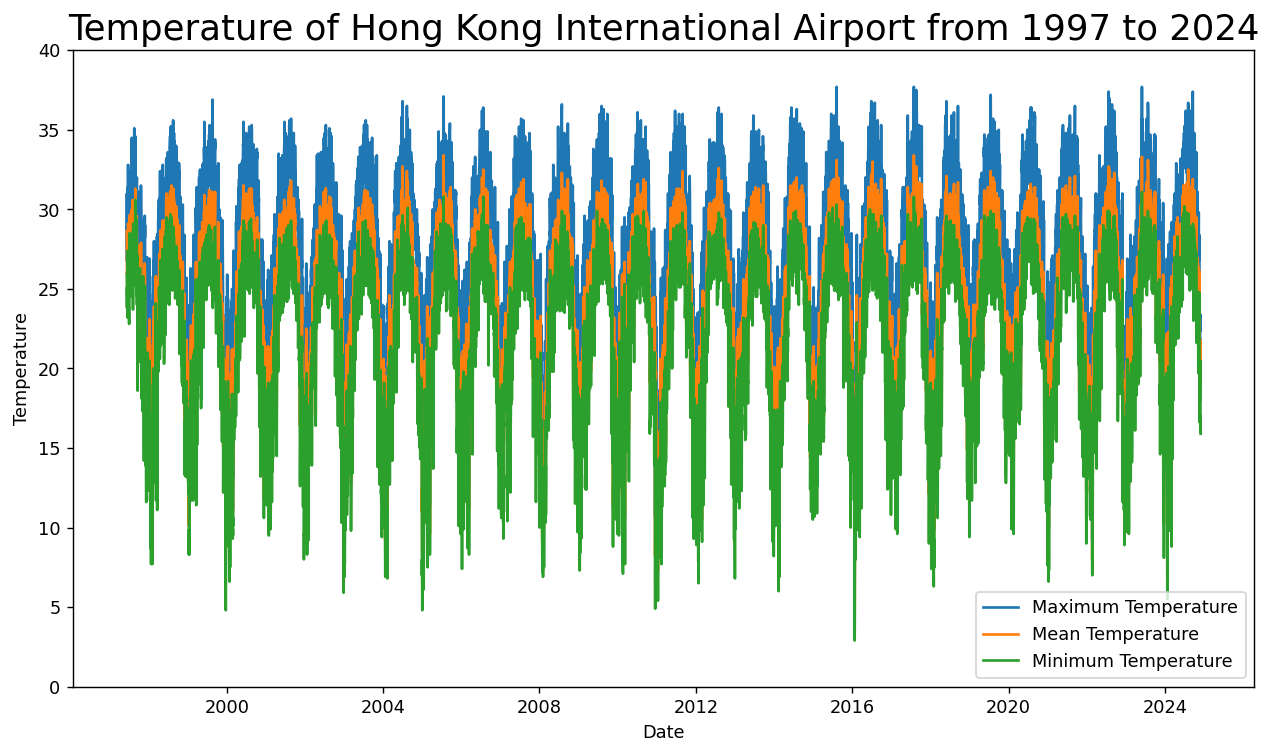

In [ ]:
# plot a temperature graph
clean_df["Date"] = pd.to_datetime(clean_df["Date"])
fig = plt.figure(dpi=128,figsize=(10,6))
dates = clean_df["Date"]
maxs = clean_df["Max Temp"]
means = clean_df["Mean Temp"]
mins = clean_df["Min Temp"]
plt.title('Temperature of '+place_full+' from 1997 to 2024',fontsize=20)
L1,=plt.plot(dates, maxs, label='Maximum Temperature')
L2,=plt.plot(dates, means, label='Mean Temperature')
L3,=plt.plot(dates, mins, label='Minimum Temperature')
y_ticks = np.linspace(0, 40, 9)
plt.yticks(y_ticks)
plt.legend(handles=[L1, L2, L3],labels=['Maximum Temperature', 'Mean Temperature', 'Minimum Temperature'], loc='best')
plt.xlabel('Date', fontsize=10)
plt.ylabel('Temperature', fontsize=10)
plt.tight_layout()
plt.tick_params(axis='both',which='major',labelsize=10)

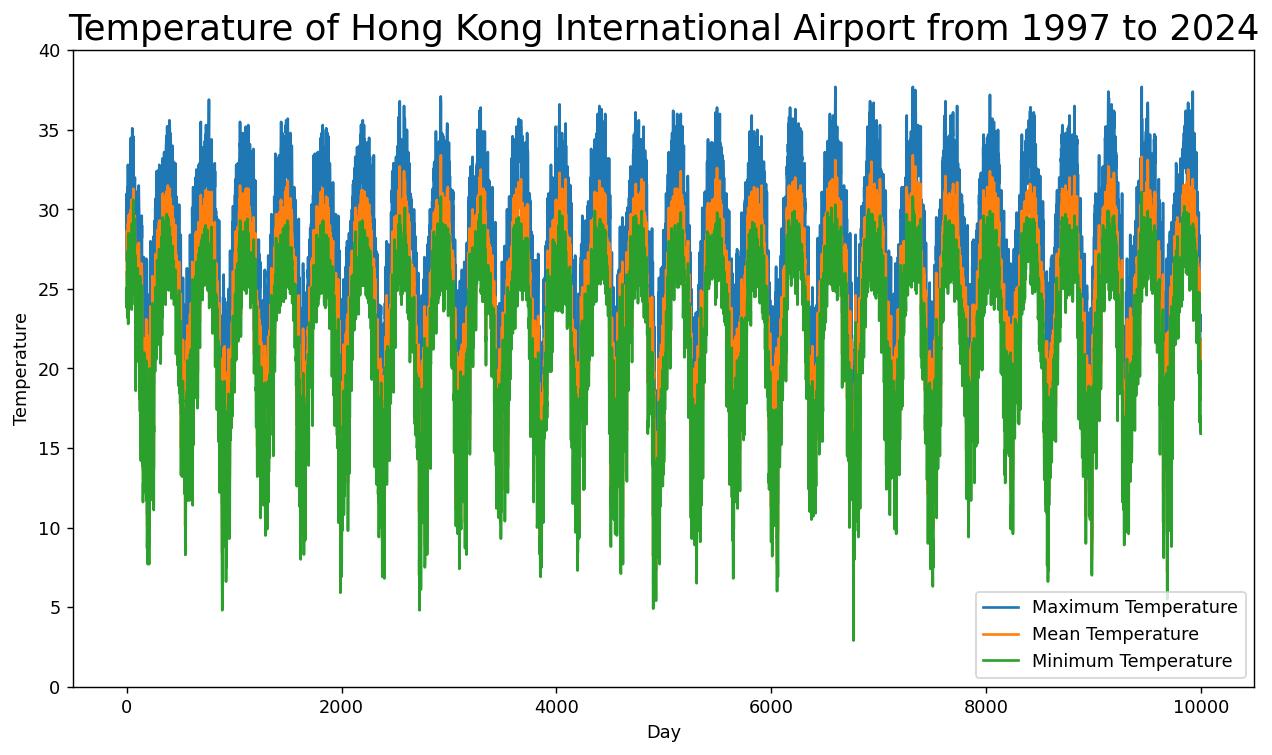

In [ ]:
# plot a graph for each day
fig = plt.figure(dpi=128,figsize=(10,6))
days = [i for i in range(len(clean_df))]
maxs = clean_df["Max Temp"]
means = clean_df["Mean Temp"]
mins = clean_df["Min Temp"]
plt.title('Temperature of '+place_full+' from 1997 to 2024',fontsize=20)
L1,=plt.plot(days, maxs, label='Maximum Temperature')
L2,=plt.plot(days, means, label='Mean Temperature')
L3,=plt.plot(days, mins, label='Minimum Temperature')
y_ticks = np.linspace(0, 40, 9)
plt.yticks(y_ticks)
plt.legend(handles=[L1, L2, L3],labels=['Maximum Temperature', 'Mean Temperature', 'Minimum Temperature'], loc='best')
plt.xlabel('Day', fontsize=10)
plt.ylabel('Temperature', fontsize=10)
plt.tight_layout()
plt.tick_params(axis='both',which='major',labelsize=10)

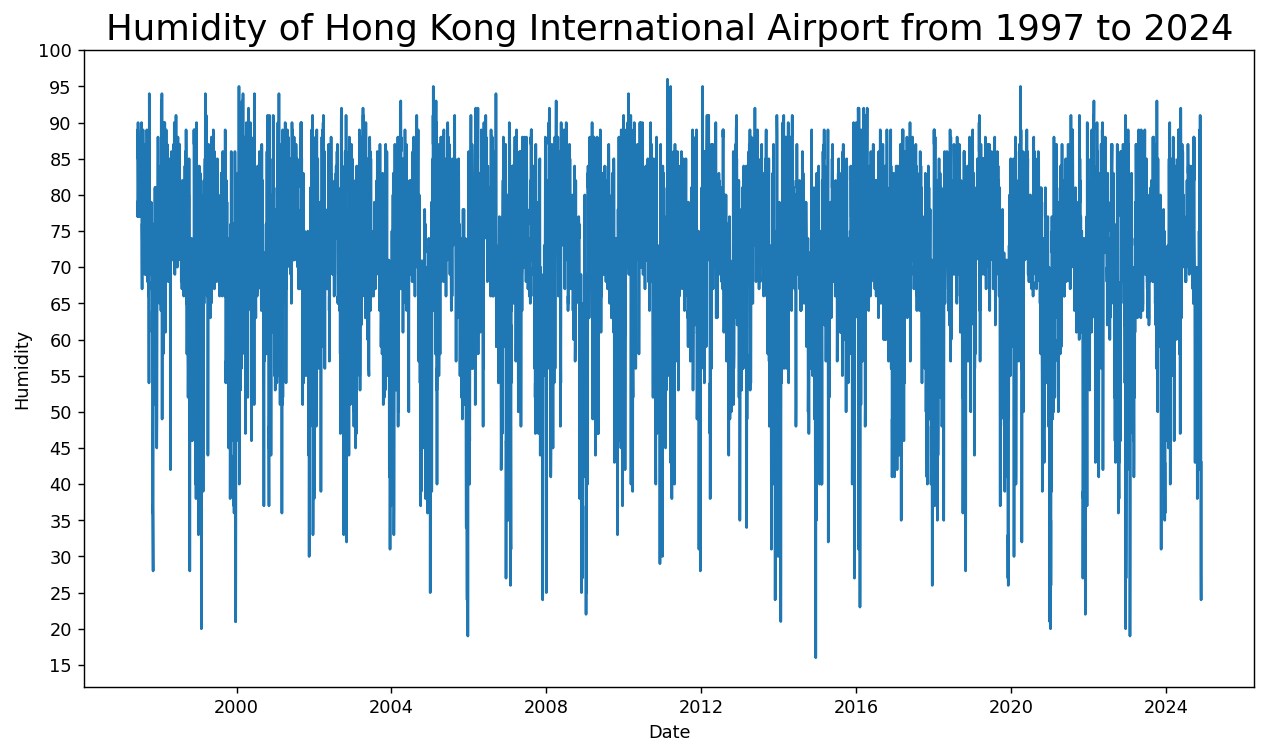

In [ ]:
# plot a humidity graph
hfig = plt.figure(dpi=128,figsize=(10,6))
dates = clean_df["Date"]
hums = clean_df["Humidity"]
plt.title('Humidity of '+place_full+' from 1997 to 2024',fontsize=20)
L1,=plt.plot(dates, hums, label='Humidity')
y_ticks = np.linspace(15, 100, 18)
plt.yticks(y_ticks)
#plt.legend(handles=[L1],labels=['Humidity'], loc='best')
plt.xlabel('Date', fontsize=10)
plt.ylabel('Humidity', fontsize=10)
plt.tight_layout()
plt.tick_params(axis='both',which='major',labelsize=10)

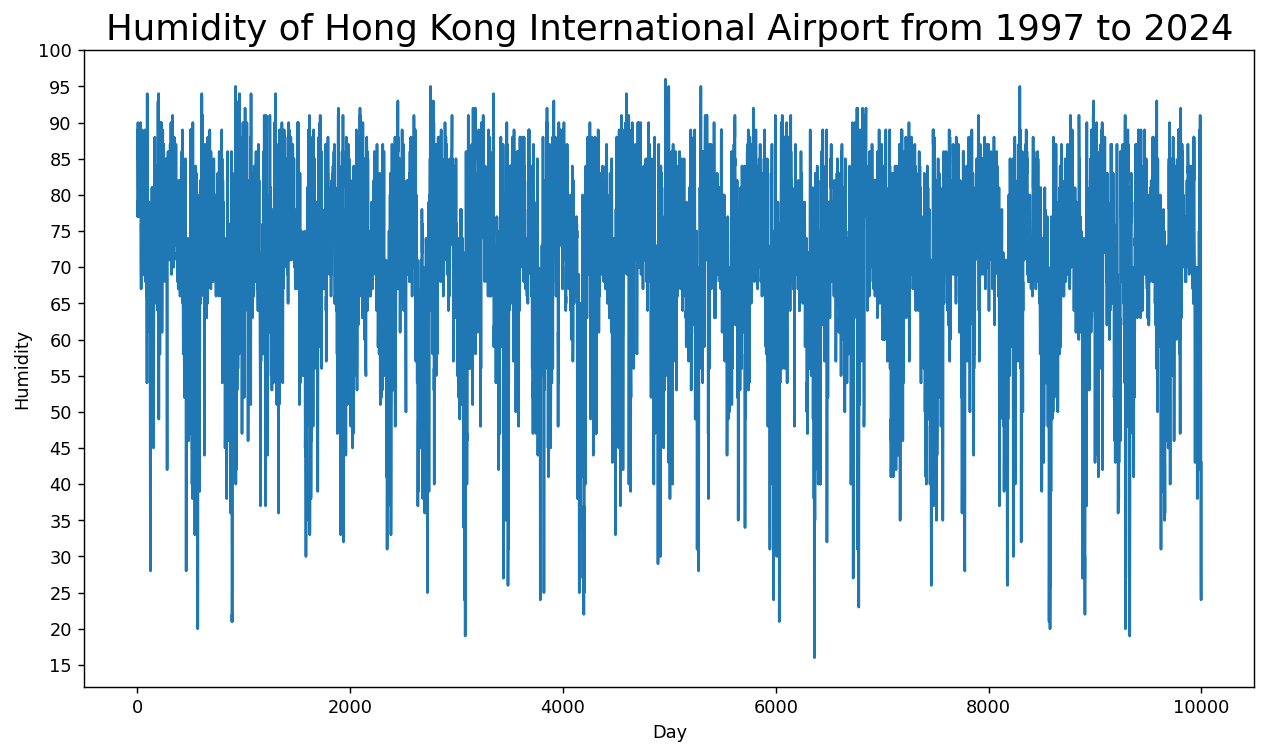

In [ ]:
# plot a humidity graph for each day
hfig = plt.figure(dpi=128,figsize=(10,6))
days = [i for i in range(len(clean_df))]
hums = clean_df["Humidity"]
plt.title('Humidity of '+place_full+' from 1997 to 2024',fontsize=20)
L1,=plt.plot(days, hums, label='Humidity')
y_ticks = np.linspace(15, 100, 18)
plt.yticks(y_ticks)
#plt.legend(handles=[L1],labels=['Humidity'], loc='best')
plt.xlabel('Day', fontsize=10)
plt.ylabel('Humidity', fontsize=10)
plt.tight_layout()
plt.tick_params(axis='both',which='major',labelsize=10)

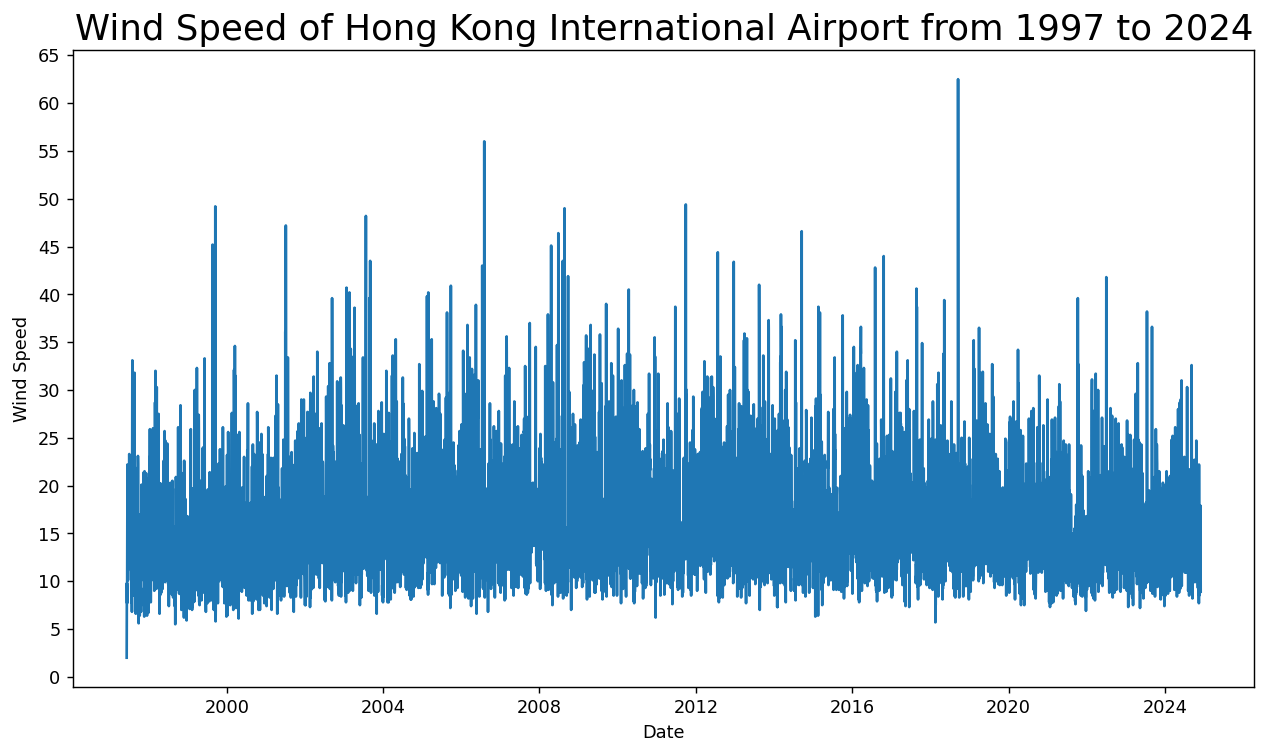

In [ ]:
# plot a wind speed graph
wfig = plt.figure(dpi=128,figsize=(10,6))
dates = clean_df["Date"]
winds = clean_df["Wind Speed"]
plt.title('Wind Speed of '+place_full+' from 1997 to 2024',fontsize=20)
L1,=plt.plot(dates, winds, label='Wind Speed')
y_ticks = np.linspace(0, 65, 14)
plt.yticks(y_ticks)
#plt.legend(handles=[L1],labels=['Wind Speed'], loc='best')
plt.xlabel('Date', fontsize=10)
plt.ylabel('Wind Speed', fontsize=10)
plt.tight_layout()
plt.tick_params(axis='both',which='major',labelsize=10)

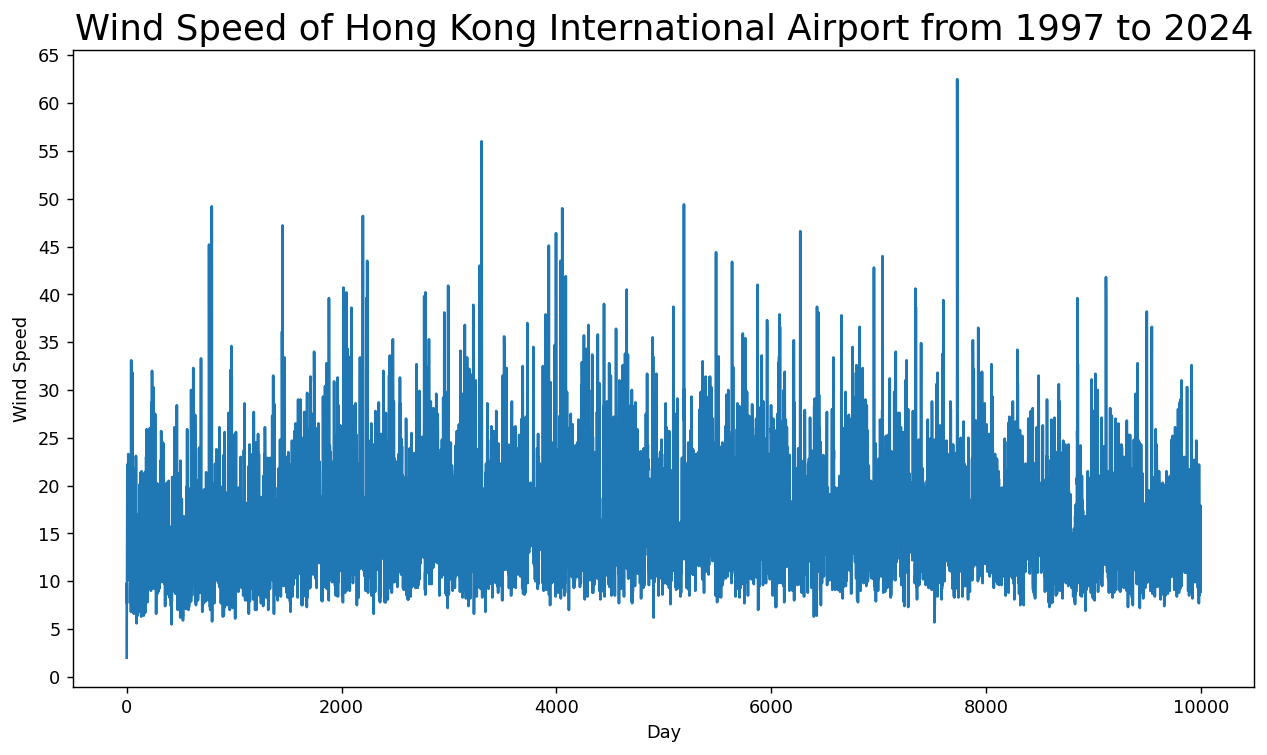

In [ ]:
# plot a wind speed graph for each day
wfig = plt.figure(dpi=128,figsize=(10,6))
days = [i for i in range(len(clean_df))]
winds = clean_df["Wind Speed"]
plt.title('Wind Speed of '+place_full+' from 1997 to 2024',fontsize=20)
L1,=plt.plot(days, winds, label='Wind Speed')
y_ticks = np.linspace(0, 65, 14)
plt.yticks(y_ticks)
#plt.legend(handles=[L1],labels=['Wind Speed'], loc='best')
plt.xlabel('Day', fontsize=10)
plt.ylabel('Wind Speed', fontsize=10)
plt.tight_layout()
plt.tick_params(axis='both',which='major',labelsize=10)

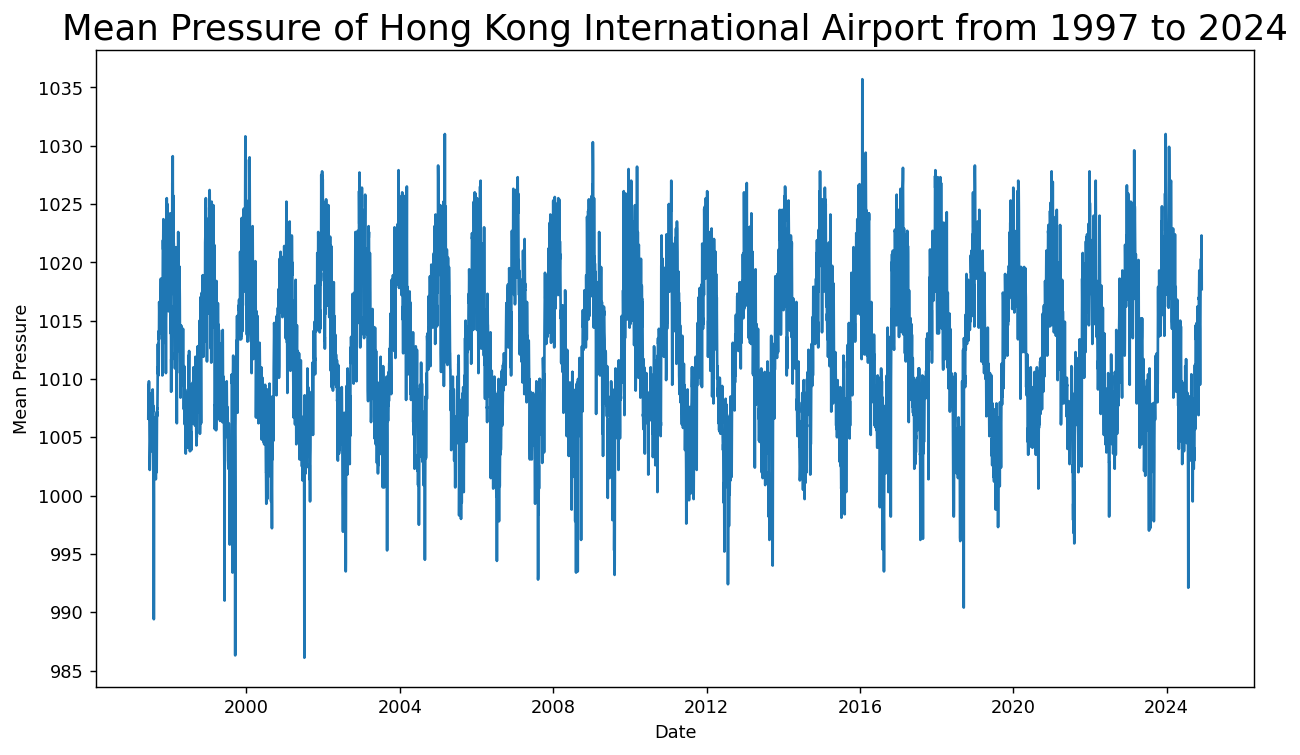

In [ ]:
# plot a mean pressure graph
pfig = plt.figure(dpi=128,figsize=(10,6))
dates = clean_df["Date"]
prs = clean_df["Mean Pressure"]
plt.title('Mean Pressure of '+place_full+' from 1997 to 2024',fontsize=20)
L1,=plt.plot(dates, prs, label='Mean Pressure')
y_ticks = np.linspace(985, 1035, 11)
plt.yticks(y_ticks)
#plt.legend(handles=[L1],labels=['Mean Pressure'], loc='best')
plt.xlabel('Date', fontsize=10)
plt.ylabel('Mean Pressure', fontsize=10)
plt.tight_layout()
plt.tick_params(axis='both',which='major',labelsize=10)

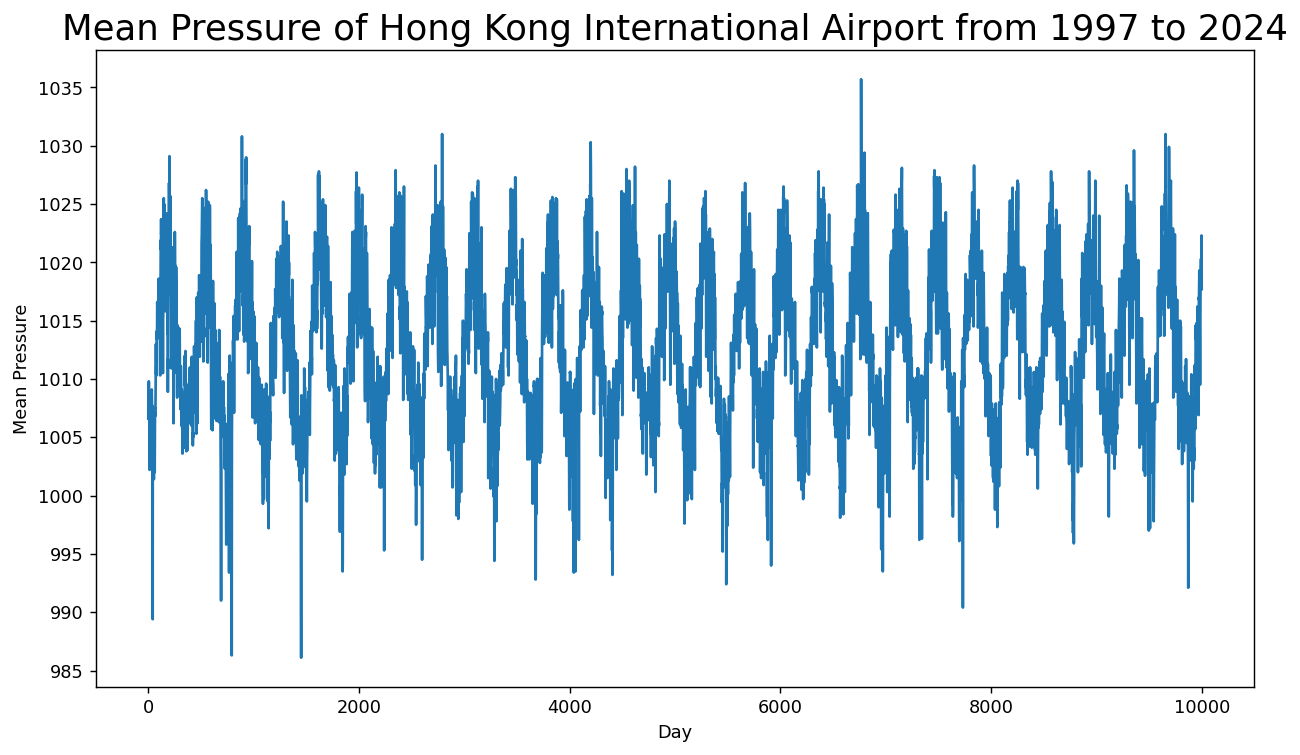

In [ ]:
# plot a mean pressure graph for each day
pfig = plt.figure(dpi=128,figsize=(10,6))
day = [i for i in range(len(clean_df))]
prs = clean_df["Mean Pressure"]
plt.title('Mean Pressure of '+place_full+' from 1997 to 2024',fontsize=20)
L1,=plt.plot(day, prs, label='Mean Pressure')
y_ticks = np.linspace(985, 1035, 11)
plt.yticks(y_ticks)
#plt.legend(handles=[L1],labels=['Mean Pressure'], loc='best')
plt.xlabel('Day', fontsize=10)
plt.ylabel('Mean Pressure', fontsize=10)
plt.tight_layout()
plt.tick_params(axis='both',which='major',labelsize=10)

# **Mean Temperature Prediction with BiLSTM Model**
Here we demonstrate mean air temperature prediction as an example. In our solution, humidity, wind speed, and indoor temperature predictions are required.

In [ ]:
# convenient entry of processed data
clean_df = pd.read_csv(path + "ALL_DATA_" + place +"_.csv", on_bad_lines = 'skip')

In [ ]:
# create train data and test data
train_size = int(len(clean_df["Mean Temp"]) * 0.8)
test_size = len(clean_df["Mean Temp"]) - train_size
train, test = clean_df.iloc[:train_size], clean_df.iloc[train_size:]
train = train[["Month", "Day", "Max Temp", "Min Temp", "Humidity", "Wind Speed", "Mean Pressure", "Humidity Pressure Ratio", "Mean Temp"]]
test = test[["Month", "Day", "Max Temp", "Min Temp", "Humidity", "Wind Speed", "Mean Pressure", "Humidity Pressure Ratio", "Mean Temp"]]
print(train.shape)
print(test.shape)
print(train.head())

(8000, 9)
(2000, 9)
   Month  Day  Max Temp  Min Temp  Humidity  Wind Speed  Mean Pressure  \
0      6   10      26.8      25.9        79         2.0         1006.6   
1      6   12      31.0      25.7        77         9.8         1009.5   
2      6   13      28.8      23.8        89         9.2         1008.2   
3      6   14      28.9      25.1        86         7.7         1007.1   
4      6   15      26.8      24.3        85        15.4         1009.6   

   Humidity Pressure Ratio  Mean Temp  
0                 0.078482       28.6  
1                 0.076275       28.1  
2                 0.088276       26.0  
3                 0.085394       26.1  
4                 0.084192       25.4  


In [ ]:
# for graph plotting and record
new = pd.concat([train, test], axis=0).reset_index().drop('index', axis=1)
new_timeseries = new[["Month", "Day", "Max Temp", "Min Temp", "Humidity", "Wind Speed", "Mean Pressure", "Humidity Pressure Ratio", "Mean Temp"]].values.astype('float32')

In [ ]:
# save dataframe
train.to_csv(path+"TRAIN_"+place+"_DATASET_.csv", encoding = "UTF-8")
test.to_csv(path+"TEST_"+place+"_DATASET_.csv", encoding = "UTF-8")

In [ ]:
# convert dataframe to numpy array
train = train.values.astype("float32")
test = test.values.astype("float32")

In [ ]:
# preprocessing -- scaling manually
train_mean = train.mean(axis=0)
train_std = train.std(axis=0)
train = (train-train_mean)/train_std

In [ ]:
# preprocessing -- scaling manually
test_mean = test.mean(axis=0)
test_std = test.std(axis=0)
test = (test-test_mean)/test_std

In [ ]:
# preprocessing -- scaling using MinMax
scaler = MinMaxScaler()
train = scaler.fit_transform(train) # curve fitting and transform to a specific range(default: 0-1)
test = scaler.transform(test) # transform to a specific range(default: 0-1)

In [ ]:
# create dataset for training and testing
def create_dataset(data, lookback):
    x = []
    y = []
    for i in range(len(data)-lookback):
        feature = data[i:i+lookback,:]
        target = data[i+lookback, :]
        x.append(feature)
        y.append(target)
    return torch.tensor(x), torch.tensor(y)


In [ ]:
# convert data into feature and target set
train_x, train_y = create_dataset(train, lookback)
test_x, test_y = create_dataset(test, lookback)
print(f"train_x: {train_x.shape}; train_y: {train_y.shape}")
print(f"test_x: {test_x.shape}; test_y: {test_y.shape}")
print(type(train_y))

train_x: torch.Size([7993, 7, 9]); train_y: torch.Size([7993, 9])
test_x: torch.Size([1993, 7, 9]); test_y: torch.Size([1993, 9])
<class 'torch.Tensor'>


C:\Users\laich\AppData\Local\Temp\ipykernel_6336\2532242701.py:10: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  return torch.tensor(x), torch.tensor(y)


In [ ]:
# load the training data with DataLoader and shuffle the data
train_loader = DataLoader(TensorDataset(train_x, train_y),batch_size = 32, shuffle = True)

In [ ]:
# define LSTM class
class LSTMModel(nn.Module):
    def __init__(self, input_size = 9, hidden_size = 256, num_layers = 2, output_size = 9):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional= True, dropout=0.3)

        # dropout layer
        # fully connected layer
        # and output layer
        self.fc = nn.Sequential(
            nn.Linear(hidden_size*2, 128),
            nn.GELU(),
            nn.LayerNorm(128),
            nn.Dropout(0.3),
            nn.Linear(128, output_size)
        )

    def forward(self, x):
        # save output from lstm layer (output, hn, cn)
        output, (_,_) = self.lstm(x)

        # shape of output = [batch_size, seq_len / time_step, hidden_size]
        out = self.fc(output[:,-1,:])
        return out

In [ ]:
# call model
model = LSTMModel()

# optimizer: Adam
optimizer = optim.Adam(model.parameters(), lr = 2e-4, weight_decay = 1e-5)

# loss func: huberloss
loss_fn = nn.HuberLoss(delta=0.5)

# scheduler (tune learning rate)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

In [ ]:
# define EarlyStopping class
class EarlyStopping:
    def __init__(self, patience = 20, delta = 0, verbose = False):
        self.patience = patience
        self.delta = delta
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.best_state = None
        self.best_y_pred = None

    def __call__(self, val_loss, model, X):
        score = -val_loss

        # if the func is called for the first time, save score, model state, predicted result
        # else, count 1 cycle until the no of cycle reach patience, stop training
        if self.best_score is None:
            self.best_score = score
            self.best_state = model.state_dict()
            with torch.no_grad():
                self.best_y_pred = model(X)
        elif score < self.best_score + self.delta:
            self.counter += 1
            # if verbose == true, print score
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}, score: {self.best_score}')

            # set early_stop condition
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            # record better score, model state and predicted result
            self.best_score = score
            self.best_state = model.state_dict()
            with torch.no_grad():
                self.best_y_pred = model(X)
            # reset counter
            self.counter = 0

In [ ]:
# define early stopping condition
Early_stop = EarlyStopping(patience = 15, verbose = True)

Epoch:  1 	 train RMSE:  0.2954512260198857 	 test RMSE 0.2905848342047934 	 Loss: 0.1103460043668747
Epoch:  2 	 train RMSE:  0.29121678715541843 	 test RMSE 0.28589766282196727 	 Loss: 0.0903894379734993
Epoch:  3 	 train RMSE:  0.2850988016656293 	 test RMSE 0.2806565062714237 	 Loss: 0.09366913139820099
Epoch:  4 	 train RMSE:  0.2833536865950747 	 test RMSE 0.27928888536242913 	 Loss: 0.08957366645336151
Epoch:  5 	 train RMSE:  0.2822172697972719 	 test RMSE 0.27856076210512054 	 Loss: 0.09023627638816833
Epoch:  6 	 train RMSE:  0.28010741576786685 	 test RMSE 0.27596380227212725 	 Loss: 0.10145238041877747
Epoch:  7 	 train RMSE:  0.27764730899563955 	 test RMSE 0.2735559070891708 	 Loss: 0.10040094703435898
Epoch:  8 	 train RMSE:  0.27634797855115484 	 test RMSE 0.272528390499126 	 Loss: 0.1213551014661789
EarlyStopping counter: 1 out of 15, score: -0.272528390499126
Epoch:  9 	 train RMSE:  0.27621786174422036 	 test RMSE 0.2729541457384937 	 Loss: 0.07210616022348404
Epoch:

C:\Users\laich\AppData\Local\Temp\ipykernel_7596\3638130529.py:70: UserWarning: Legend does not support handles for list instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/users/explain/axes/legend_guide.html#controlling-the-legend-entries
  plt.legend(handles=[L1, L2],labels=['train loss', 'test loss'], loc='best')


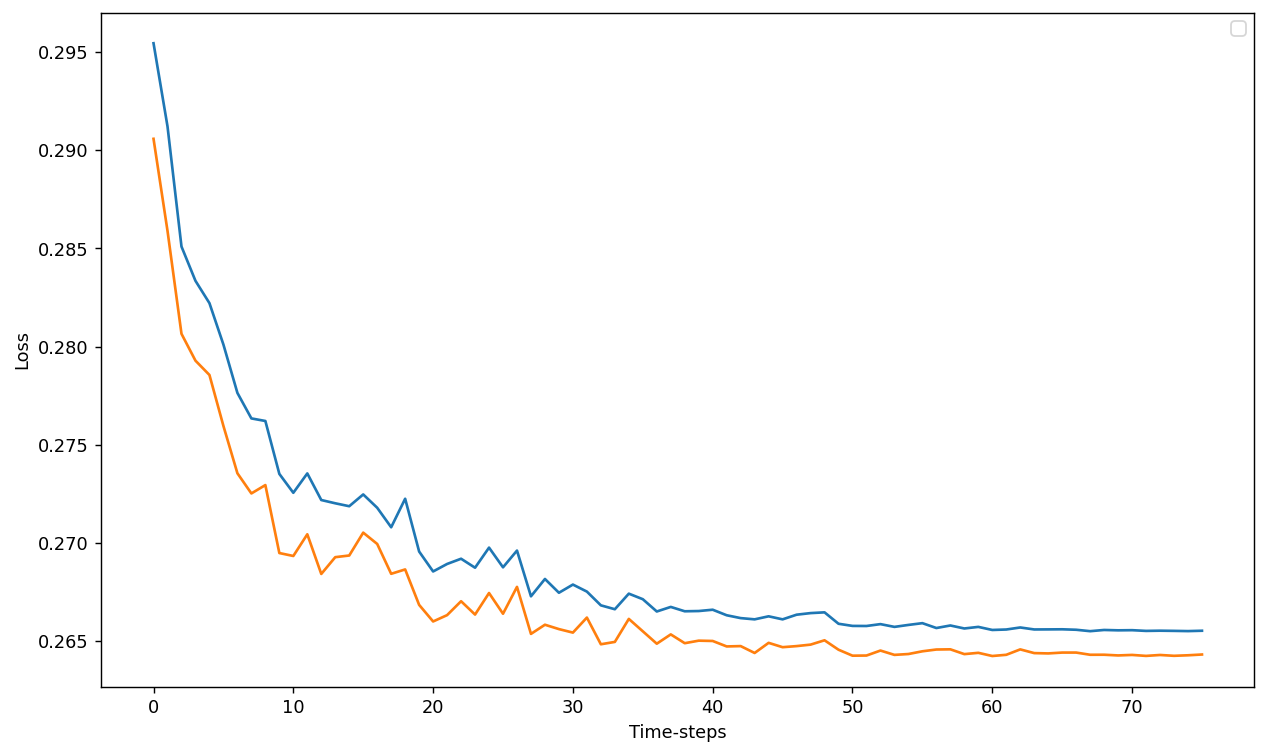

In [ ]:
# save best score, weightings, training set prediction and testing set prediction
best_score = None
best_weights = None
best_train_preds = None
best_test_preds = None

# set epochs
epochs = 100
tr_rmse = []
te_rmse = []

for e in range(epochs):
    # training
    model.train()

    for batch_x, batch_y in train_loader:
        pred_y = model(batch_x)
        # print(pred_y.shape, batch_x.shape, batch_y.shape)
        loss = loss_fn(pred_y, batch_y)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

    # evaluation
    model.eval()

    with torch.no_grad():
        # save train error and result
        pred_y = model(train_x)
        # print(pred_y.shape, train_y.shape)
        train_rmse = np.sqrt(loss_fn(pred_y, train_y).item())
        tr_rmse.append(train_rmse)
        train_preds = pred_y.clone().detach().cpu().numpy()

        # save test error and result
        pred_y = model(test_x)
        # print(pred_y.shape, test_y.shape)
        test_rmse = np.sqrt(loss_fn(pred_y, test_y).item())
        te_rmse.append(test_rmse)
        test_preds = pred_y.clone().detach().cpu().numpy()

        # update scheduler
        scheduler.step(test_rmse)

        # save better score, weights, train prediction and test prediction
        if best_score is None or test_rmse < best_score:
            best_score = test_rmse
            best_weights = model.state_dict()
            best_train_preds = train_preds
            best_test_pred = test_preds

        # call EarlyStopping func
        Early_stop(test_rmse, model, test_x)

        # check if early stopping condition reached
        # if so, stop training
        if Early_stop.early_stop:
            print("Early Stopping")
            break

        # print error every 10 ecpochs
        print('Epoch: ', e+1, '\t train RMSE: ', train_rmse, '\t test RMSE', test_rmse, '\t Loss:', loss.item())

# plot graph for train_rmse and test_rmse
fig = plt.figure(dpi=128,figsize=(10,6))
times = [i for i in range(1, len(te_rmse)+1)]
L1 = plt.plot(times, tr_rmse, label="train loss")
L2 = plt.plot(times, te_rmse, label="test loss")
plt.legend(handles=[L1, L2],labels=['train loss', 'test loss'], loc='best')
plt.ylabel('Loss', fontsize=10)
plt.xlabel('Time-steps', fontsize=10)
plt.tight_layout()
plt.tick_params(axis='both',which='major',labelsize=10)
plt.show()

# save model, weights, prediction result
if best_weights is not None:
    model.load_state_dict(best_weights)

    # save best weight
    best_model_weights_path = os.path.join(path, 'best_model_weights.pth')
    torch.save(best_weights, best_model_weights_path)

    # save model
    best_model_path = os.path.join(path, 'best_model.pth')
    torch.save(model.state_dict(), best_model_path)

    # save other parameters
    params = {
    'best_score': best_score,
    'best_train_preds': best_train_preds,
    'best_test_preds': best_test_preds,
    'epochs': epochs
    }
    params_path = os.path.join(path, 'training_params.pth')
    torch.save(params, params_path)

    with torch.no_grad():
        pred_y_train = model(train_x).clone().detach().cpu().numpy()
        pred_y_test = model(test_x).clone().detach().cpu().numpy()

In [ ]:
# load trained model from depository
model = LSTMModel()

# load best scored
best_model_weights_path = os.path.join(path, 'best_model_weights.pth')
model.load_state_dict(torch.load(best_model_weights_path))
# load the whole model
# best_model_path = os.path.join(path, 'best_model.pth')
# model = torch.load(best_model_path)

# evaluation
model.eval()

# load other parameters
params_path = os.path.join(path, 'training_params.pth')
params = torch.load(params_path)
best_score = params['best_score']
best_train_preds = params['best_train_preds']
best_test_preds = params['best_test_preds']
epochs = params['epochs']

In [ ]:
# save model, weights, prediction result
if best_weights is not None:
    model.load_state_dict(best_weights)

    # save best weight
    best_model_weights_path = os.path.join(path, 'best_model_weights1.pth')
    torch.save(best_weights, best_model_weights_path)

    # save model
    best_model_path = os.path.join(path, 'best_model1.pth')
    torch.save(model.state_dict(), best_model_path)

    # save other parameters
    params = {
    'best_score': best_score,
    'best_train_preds': best_train_preds,
    'best_test_preds': best_test_preds,
    'epochs': epochs
    }
    params_path = os.path.join(path, 'training_params1.pth')
    torch.save(params, params_path)


In [ ]:
# multi-variate time-series prediction
def predict_future(model, initial_sequence, num_steps):
    model.eval()
    current_sequence = initial_sequence.copy()
    predictions = []

    # generate prediction for the next num_steps
    for _ in range(num_steps):
        input_tensor = torch.FloatTensor(current_sequence).unsqueeze(0)
        with torch.no_grad():
            output = model(input_tensor).numpy()[0]

        # create new predicted data
        for i in range(1, num_steps):
            current_sequence[i-1,:] = current_sequence[i,:]
        current_sequence[num_steps-1, :] = output
        new_step = output
        predictions.append(new_step)

    return np.array(predictions)

In [ ]:
# data processing for prediction
train_ = pd.read_csv(path+"TRAIN_"+place+"_DATASET_.csv")
test_ = pd.read_csv(path+"TEST_"+place+"_DATASET_.csv")
train_ = train_.values.astype("float32")
test_ = test_.values.astype("float32")
x_train = train_[-(lookback):,1:]
y_train = x_train[:,-1]
x_test = test_[-(lookback*2):-lookback,1:]
y_test = x_test[:,-1]
scaler = MinMaxScaler()
x_test = scaler.fit_transform(x_test)

In [ ]:
# make prediction
future_steps = 7
predictions = predict_future(model, x_test, future_steps)

# undo scaling
predicted_temps = scaler.inverse_transform(np.array(predictions))
print(f"Temperature predictions of coming {future_steps} days:", predicted_temps[:,-1])

Temperature predictions of coming 7 days: [21.247303 23.116867 24.013979 24.439445 24.696856 24.879835 25.013449]


In [ ]:
# plot graph for prediction result
def plot_prediction(previous_data, predictions, num_steps, title):
    time_steps = [i for i in range(-previous_data.shape[0],0)]

    plt.figure(dpi=128,figsize=(10,6))
    plt.title(title,fontsize=20)
    L1, = plt.plot(time_steps, previous_data[:,-1],label = "History Temperature")
    L2, = plt.plot([i for i in range(num_steps)], predictions,marker="o", markersize=10,label="Predicted Temperature")
    plt.legend(handles=[L1, L2],labels=['History Temperature', 'Predicted Temperature'], loc='best')
    plt.ylabel('Temperature', fontsize=10)
    plt.xlabel('Time-steps', fontsize=10)
    plt.tight_layout()
    plt.tick_params(axis='both',which='major',labelsize=10)
    return plt

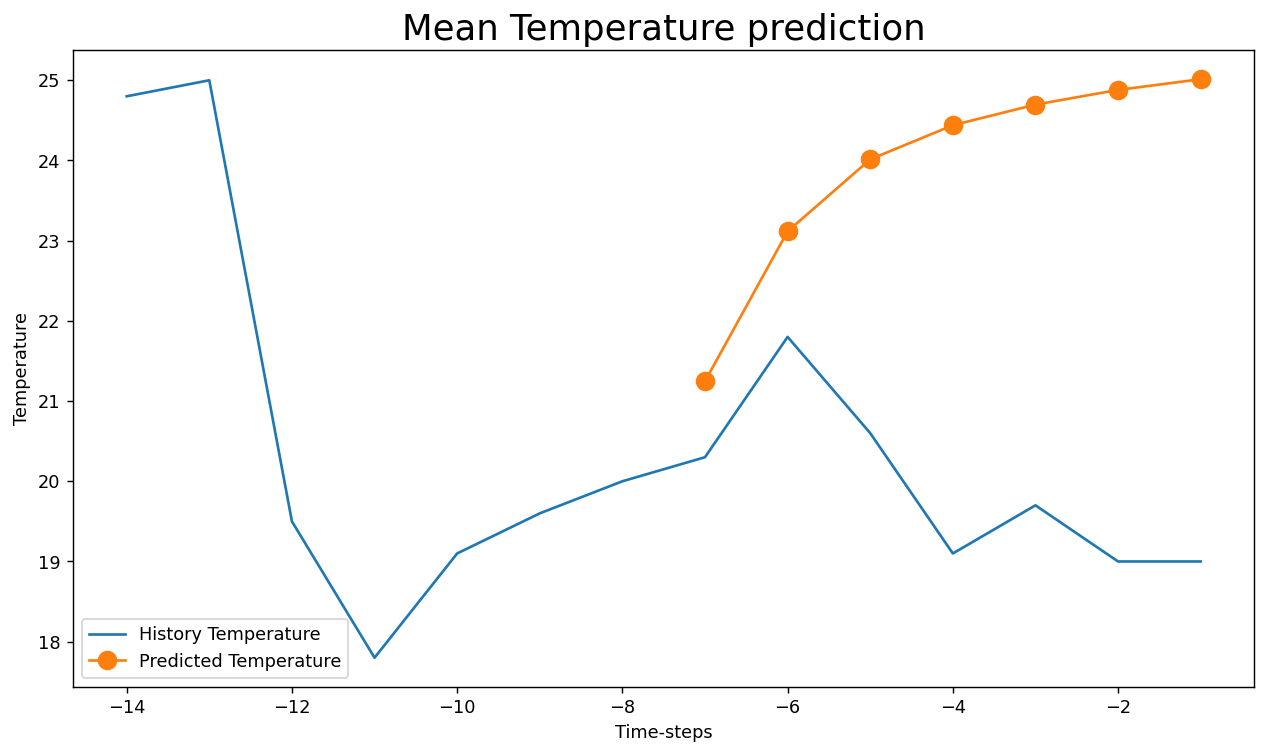

In [ ]:
time_steps = [i for i in range(-test_[-(lookback*2):,1:].shape[0],0)]

plt.figure(dpi=128,figsize=(10,6))
plt.title("Mean Temperature prediction",fontsize=20)
L1, = plt.plot(time_steps, test_[-(lookback*2):,-1],label = "History Temperature")
L2, = plt.plot([i for i in range(-lookback,0)], predicted_temps[:,-1],marker="o", markersize=10,label="Predicted Temperature")
plt.legend(handles=[L1, L2],labels=['History Temperature', 'Predicted Temperature'], loc='best')
plt.ylabel('Temperature', fontsize=10)
plt.xlabel('Time-steps', fontsize=10)
plt.tight_layout()
plt.tick_params(axis='both',which='major',labelsize=10)

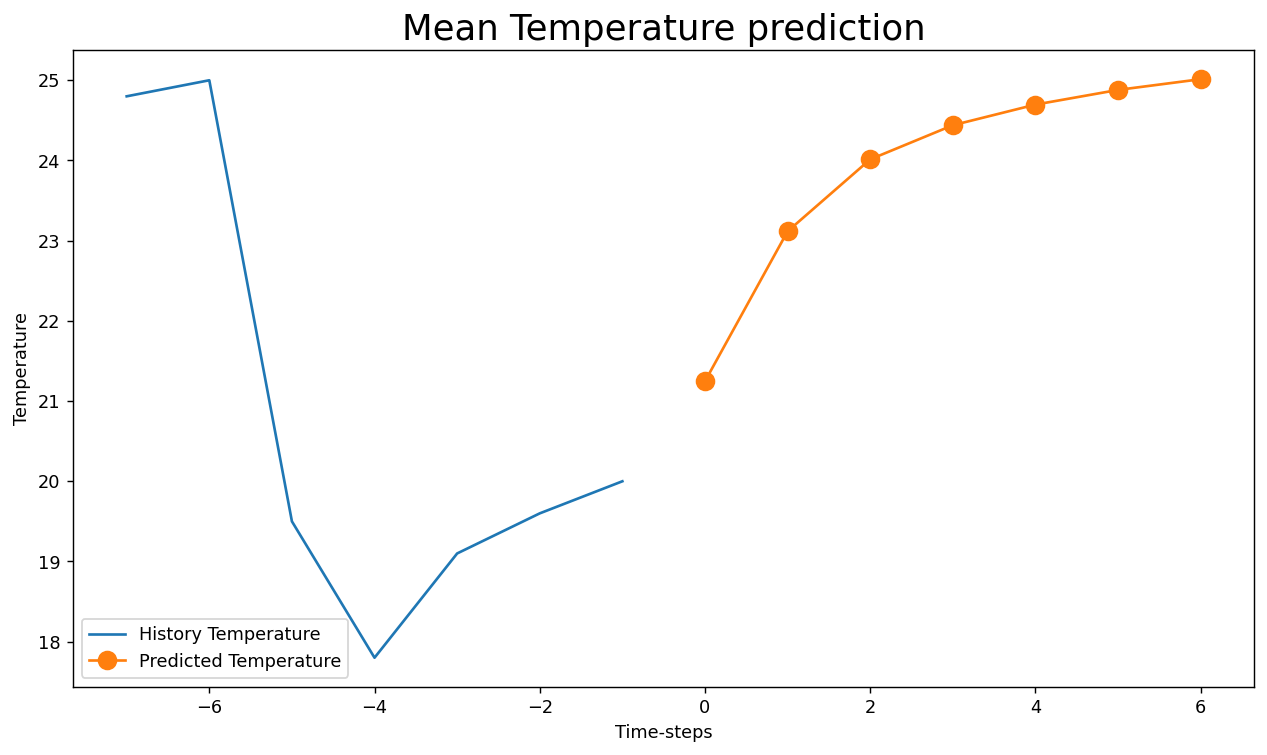

In [ ]:
# show graph
graph = plot_prediction(test_[-(lookback*2):-lookback,1:], predicted_temps[:,-1] , 7, "Mean Temperature prediction")

# **Air Conditioner Temperature Setting**
In this section, we will compare RBC and AC-MPC and evaluate their performance on HVAC system operation. It is proved that AC-MPC can achieve precision temperature control to reduce energy consumption and maintain stable indoor temperature.

# **Rule Based Control (RBC)**
Rule Based Control is traditional way to regulate and restrict the behaviors by rules. The rules are set based on the engineer's experience. The following codes illustrate a simple HVAC system control by RBC.

In [ ]:
# prepare data
test_hkt = pd.read_excel(path+"a001-1f-msr-tp01_timeseries.xlsx")

test_hkt["ts"] = pd.to_datetime(test_hkt["ts"].astype(float) / 1000.0, unit='s')

test_hkt.set_index('ts', inplace=True)

test_data = test_hkt.resample('H').first()

test_data["temperature"].fillna(method="ffill", inplace=True)

hkt_test_df = test_data[["temperature"]].iloc[2000:4000]

print(hkt_test_df.head())

In [ ]:
# create indoor temperature data
def mock_outdoor_temp(data):
    indoor_temp = []
    for i in range(len(data)):
        temp = data[i] + random.uniform(-5,5)
        indoor_temp.append(temp)
    return np.array(indoor_temp)

In [ ]:
# add mock indoor temperature to the data
indtemp = mock_outdoor_temp(list(hkt_test_df["temperature"]))
hkt_test_df["Outdoor Temp"] = indtemp

In [ ]:
# construct a simple class to set the ac temp with
class AC_Temp_Control:
  def __init__(self, average_temp = 22, buffer = 2):
    self.average_temp = average_temp
    self.buffer = buffer

  def auto_ac_control(self, data, column_name):
    ac_temp = []
    for i in range(len(data)):
      ac_temp.append(self.temp_set(data[column_name].iloc[i]))

    return ac_temp

  def temp_set(self, temp):
    if temp <= 20:
      return self.average_temp + self.buffer
    elif temp > 20 and temp <= 25:
      return self.average_temp
    elif temp > 25:
      return self.average_temp - self.buffer

In [ ]:
# Set the temperature of AC
AC_Temp_Simple = AC_Temp_Control(buffer=5)
temps = AC_Temp_Simple.auto_ac_control(hkt_test_df, "temperature")
ac_temp = hkt_test_df
ac_temp["AC Temp"] = temps
print(ac_temp.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2000 entries, 2024-04-09 16:00:00 to 2024-07-01 23:00:00
Freq: h
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   temperature   2000 non-null   float64
 1   Outdoor Temp  2000 non-null   float64
 2   AC Temp       2000 non-null   int64  
dtypes: float64(2), int64(1)
memory usage: 62.5 KB
None


In [ ]:
# calculate the new indoor temperature after setting AC temperature
def indoor_temp_change(ac_temp, indoor_temp, outdoor_temp, room_heat_capacity=1000,
                       ac_capacity=10, outdoor_heat_coeff=0.5,
                       time_step=1.0):
    # heat exchange
    q_ac = ac_capacity * (ac_temp - indoor_temp) * time_step
    q_outdoor = outdoor_heat_coeff * (outdoor_temp - indoor_temp) * time_step
    delta_temp = (q_ac + q_outdoor) / room_heat_capacity
    indoor_temp += delta_temp
    indoor_temp = np.clip(indoor_temp, 10.0, 40.0)

    return indoor_temp


In [ ]:
# calculate energy consumption (kW)
def energy_consume(ac_temp, indoor_temp, ac_capacity=10, time_step=1):
    ac_temp = np.array(ac_temp)
    indoor_temp = np.array(indoor_temp)
    energy = ac_capacity * abs(ac_temp - indoor_temp) * time_step
    return energy

In [ ]:
# temperature control and energy consumption based test data
ac_temp["Final Indoor Temp"] = np.nan
for index, row in ac_temp.iterrows():
    ac_temp.loc[index, "Final Indoor Temp"] = indoor_temp_change(
        row["AC Temp"], row["temperature"], row["Outdoor Temp"], time_step=1/24
    )
energy = energy_consume(ac_temp["AC Temp"], ac_temp["temperature"])
ac_temp["Energy Consumption"] = energy
ac_temp.head()

temperature  Outdoor Temp  AC Temp  Final Indoor Temp  \
ts                                                                           
2024-04-09 16:00:00         25.8     27.325825       17          25.796365   
2024-04-09 17:00:00         25.8     25.143889       17          25.796320   
2024-04-09 18:00:00         25.6     25.134558       17          25.596407   
2024-04-09 19:00:00         25.5     24.729912       17          25.496442   
2024-04-09 20:00:00         25.6     26.484043       17          25.596435   

                     Energy Consumption  
ts                                       
2024-04-09 16:00:00                88.0  
2024-04-09 17:00:00                88.0  
2024-04-09 18:00:00                86.0  
2024-04-09 19:00:00                85.0  
2024-04-09 20:00:00                86.0

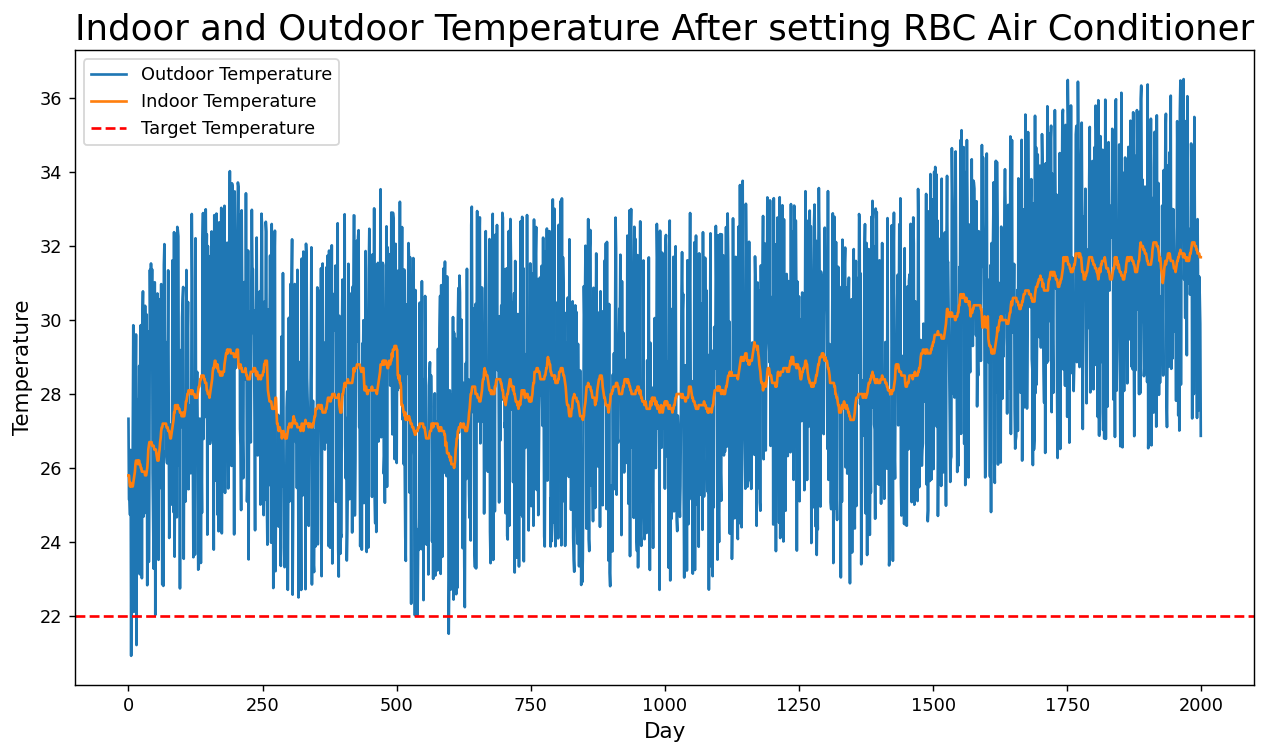

In [ ]:
# Indoor and Outdoor temperature visualization
days = [i for i in range(2000)]
plt.figure(dpi=128,figsize=(10,6))
plt.title('Indoor and Outdoor Temperature After setting RBC Air Conditioner',fontsize=20)
L1,=plt.plot(days,ac_temp["Outdoor Temp"], label='Outdoor Temperature')
L2,=plt.plot(days,ac_temp["Final Indoor Temp"], label='Indoor Temperature')
plt.axhline(22, color='red', linestyle='--', label='Target Temperature')
plt.legend()
plt.xlabel("Day", fontsize=12)
plt.ylabel('Temperature', fontsize=12)
plt.tight_layout()
plt.tick_params(axis='both',which='major',labelsize=10)

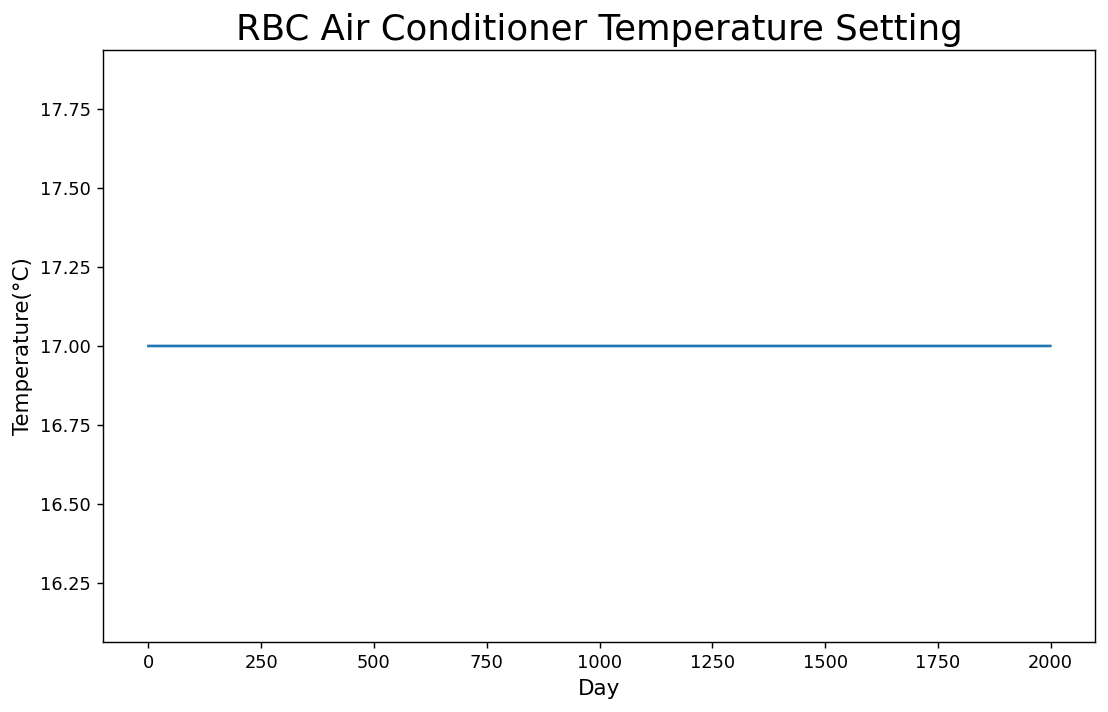

In [ ]:
# AC Temperauture visualization
days = [i for i in range(2000)]
plt.figure(dpi=128,figsize=(10,6))
plt.title("RBC Air Conditioner Temperature Setting", fontsize=20)
plt.plot(days, ac_temp["AC Temp"])
plt.ylabel("Temperature(°C)", fontsize=12)
plt.xlabel("Day", fontsize=12)
plt.show()

In [ ]:
# calculate temperature error
temp_errors = np.abs(np.array(ac_temp["Final Indoor Temp"])-22)
avg_energy = np.mean(energy)

# print test results
print("\n" + "="*40)
print(f"{' Test report ':=^40}")
print(f"Average temperature error: {np.mean(temp_errors):.2f} ± {np.std(temp_errors):.2f} °C")
print(f"Average energy consumption: {avg_energy:.2f} ± {np.std(energy):.2f} kW")
print("="*40)


============= Test report ==============
Average temperature error: 6.73 ± 1.49 °C
Average energy consumption: 117.31 ± 14.87 kW


# **Actor-Critic Model Predictive Control (AC-MPC) Simulation**
In **AirSmart**, AC-MPC is applied to precisely predict the behaviours of the HVAC system. The following codes show a **simple demonstration** of how AC-MPC is applied in our system to control the temperature setting.

In [ ]:
# preprocess train data
train_hkt = pd.read_excel(path+"a001-1f-elr_vec-tp01_timeseries.xlsx")

train_hkt["ts"] = pd.to_datetime(train_hkt["ts"].astype(float) / 1000.0, unit='s')

train_hkt.set_index('ts', inplace=True)

train_data = train_hkt.resample('H').first()

train_data["temperature"].fillna(method="ffill", inplace=True)

print(train_data.info())

train_temps = np.array(train_data["temperature"])

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8360 entries, 2024-01-17 08:00:00 to 2024-12-30 15:00:00
Freq: h
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   battery_voltage  8314 non-null   float64
 1   ci               8314 non-null   object 
 2   humidity         8314 non-null   float64
 3   rsrp             8314 non-null   float64
 4   rsrq             8314 non-null   float64
 5   rssi             8314 non-null   float64
 6   sn               8314 non-null   float64
 7   temperature      8360 non-null   float64
dtypes: float64(7), object(1)
memory usage: 587.8+ KB
None


C:\Users\laich\AppData\Local\Temp\ipykernel_26768\1079907600.py:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  train_data = train_hkt.resample('H').first()
C:\Users\laich\AppData\Local\Temp\ipykernel_26768\1079907600.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data["temperature"].fillna(method="ffill", inplace=True)
C:\Users\laich\AppData\Local\Temp\ipykernel_26768\1079907600.py:9: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a 

In [ ]:
# preprocess test data
test_hkt = pd.read_excel(path+"a001-1f-msr-tp01_timeseries.xlsx")

test_hkt["ts"] = pd.to_datetime(test_hkt["ts"].astype(float) / 1000.0, unit='s')

test_hkt.set_index('ts', inplace=True)

test_data = test_hkt.resample('H').first()

test_data["temperature"].fillna(method="ffill", inplace=True)

print(test_data.info())

test_temps = np.array(test_data["temperature"])
test_temps = test_temps[2000:4000]

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8360 entries, 2024-01-17 08:00:00 to 2024-12-30 15:00:00
Freq: h
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   battery_voltage  8280 non-null   float64
 1   ci               8280 non-null   object 
 2   humidity         8280 non-null   float64
 3   rsrp             8280 non-null   float64
 4   rsrq             8280 non-null   float64
 5   rssi             8280 non-null   float64
 6   sn               8280 non-null   float64
 7   temperature      8360 non-null   float64
dtypes: float64(7), object(1)
memory usage: 587.8+ KB
None


C:\Users\laich\AppData\Local\Temp\ipykernel_26768\70340289.py:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  test_data = test_hkt.resample('H').first()
C:\Users\laich\AppData\Local\Temp\ipykernel_26768\70340289.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_data["temperature"].fillna(method="ffill", inplace=True)
C:\Users\laich\AppData\Local\Temp\ipykernel_26768\70340289.py:9: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future ve

In [ ]:
# Custom environment for air conditioner control
class ACControlEnv(gym.Env):
    def __init__(self, historical_temps, room_heat_capacity=1000, ac_capacity=10, \
                 outdoor_heat_coeff=0.5, target_temp=22, time_step=1.0, hist_len=10, ac_power=1.0):
        super().__init__()

        # ensure the historical data is longer than the required length
        assert len(historical_temps) >= hist_len

        self.historical_temps = historical_temps  # Now this is indoor temperature history
        self.room_heat_capacity = room_heat_capacity  # unit: kJ/°C
        self.ac_capacity = ac_capacity  # kW/°C
        self.outdoor_heat_coeff = outdoor_heat_coeff  # unit: kW/°C
        self.target_temp = target_temp
        self.time_step = time_step  # unit: day
        self.hist_len = hist_len
        # custom the temperature of air conditioner (16-30 degree Celsius)
        self.action_space = gym.spaces.Discrete(15)
        # custom a space for air conditioner
        self.observation_space = gym.spaces.Box(
            low=np.array([[10.0, -10.0]] * hist_len, dtype=np.float32),
            high=np.array([[40.0, 40.0]] * hist_len, dtype=np.float32),
            shape=(hist_len, 2),
            dtype=np.float32
        )
        # initialization
        self.current_step = 0
        self.indoor_temp = self.historical_temps[self.current_step]
        self.outdoor_temp = self.historical_temps[self.current_step] + random.uniform(-5, 5)
        self.last_temp = target_temp
        self.history = deque(maxlen=hist_len)  # store the data of past 10 days
        self.ac_power = ac_power  # unit: kW

    def reset(self):
        # reset the state
        self.current_step = 0
        self.indoor_temp = self.historical_temps[self.current_step]
        self.outdoor_temp = self.historical_temps[self.current_step] + random.uniform(-5, 5)
        self.outdoor_temp = np.clip(self.outdoor_temp, 10.0, 40.0)
        self.history.clear()
        for i in range(min(self.hist_len, len(self.historical_temps))):
            indoor_temp = self.historical_temps[i]
            outdoor_temp = indoor_temp + random.uniform(-5, 5)  # Generate outdoor temp based on indoor temp
            outdoor_temp = np.clip(outdoor_temp, -10.0, 40.0)
            self.history.append([indoor_temp, outdoor_temp])
        self.last_temp = self.indoor_temp
        return self._get_obs()

    def step(self, action):
        indoor_temp = self.historical_temps[self.current_step]
        # Generate outdoor temperature based on indoor temperature with some noise
        self.outdoor_temp = indoor_temp + random.uniform(-5, 5)
        self.outdoor_temp = np.clip(self.outdoor_temp, -10.0, 40.0)

        # Map action to temperature setting with noise
        noise = np.random.uniform(-1, 1)
        ac_temp = int(action) + 16 + noise
        ac_temp = np.clip(ac_temp, 16.0, 30.0)

        # Simulate indoor temperature change
        q_ac = self.ac_capacity * (ac_temp - self.indoor_temp) * self.time_step
        q_outdoor = self.outdoor_heat_coeff * (self.outdoor_temp - self.indoor_temp) * self.time_step
        delta_temp = (q_ac + q_outdoor) / self.room_heat_capacity
        self.indoor_temp += delta_temp
        self.indoor_temp = np.clip(self.indoor_temp, 10.0, 40.0)  # Constrain indoor temperature

        # reward calculation
        reward = self.calculate_reward()

        self.history.append([self.indoor_temp, self.outdoor_temp])
        self.last_temp = self.indoor_temp

        self.current_step += 1
        done = self.current_step >= len(self.historical_temps)

        return self._get_obs(), reward, done, {}

    def calculate_reward(self):
        # take energy efficiency and indoor temperature stability into account
        temp_error = abs(self.indoor_temp - self.target_temp)
        stability = np.exp(-0.5 * (self.indoor_temp - self.last_temp) ** 2)
        energy_cost = self.ac_power * self.time_step

        # set weighting
        temp_weight = 1.0 if temp_error > 2 else 0.5
        reward = (
                -temp_weight * temp_error
                + 0.5 * stability
                - 0.02 * energy_cost
        )
        return reward

    def _get_obs(self):
        # return the observed values of the past 10 days
        while len(self.history) < self.hist_len:
            self.history.appendleft(self.history[0])

        return np.array(self.history, dtype=np.float32)[-self.hist_len:]

In [ ]:
# test the environment class
historical_temps = np.random.uniform(15, 30, 20)  # mock historical temperature data
print(historical_temps.shape)
env = ACControlEnv(
    historical_temps=historical_temps,
    hist_len=10
)

# print initial states
obs = env.reset()
print("Initial observation data shape:", obs.shape)  # 应为(10,2)
print("Initial room temperature:", obs[-1, 0])

# print states after 1 action
action = 5  # i.e. 16+5=21°C
next_obs, reward, done, _ = env.step(action)
print("\nObaservation data shape after 1 action:", next_obs.shape)
print("New room temperature:", next_obs[-1, 0])
print("Value of reward:", reward)

(20,)
Initial observation data shape: (10, 2)
Initial room temperature: 22.704031

Obaservation data shape after 1 action: (10, 2)
New room temperature: 20.21194
Value of reward: -0.41405036732510103


In [ ]:
# define Actor Model
class Actor(nn.Module):
    def __init__(self, action_dim, state_dim=2):
        super().__init__()
        # As we wish to process temp data of past 10 days, we need lstm layer to capture time features
        self.lstm = nn.LSTM(input_size=state_dim,
                            hidden_size=64,
                            num_layers=1,
                            batch_first=True)

        self.fc = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.LayerNorm(32),
            nn.Dropout(0.4),
            nn.Linear(32, action_dim)
        )

    def forward(self, s):
        if isinstance(s, np.ndarray):
            s = torch.FloatTensor(s)
        out, (h_n, _) = self.lstm(s)
        action_probs = F.softmax(self.fc(out[:,-1,:]), dim=-1)
        return action_probs

# define Critic Model
class Critic(nn.Module):
    def __init__(self, state_dim=2):
        super().__init__()
        self.lstm = nn.LSTM(state_dim,64,batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.LayerNorm(32),
            nn.Dropout(0.4),
            nn.Linear(32, 1)
        )

    def forward(self, s):
        if isinstance(s, np.ndarray):
            s = torch.FloatTensor(s)
        out, _ = self.lstm(s)
        value = self.fc(out[:, -1, :])

        return value.squeeze(-1)

In [ ]:
# build AC model
class Actor_Critic:
    def __init__(self, env, gamma=0.99, lr_a=3e-4, lr_c=5e-4):
        self.gamma = gamma
        self.lr_a = lr_a
        self.lr_c = lr_c

        # build AC model
        self.actor = Actor(env.action_space.n)
        self.critic = Critic()

        self.critic_target = Critic()
        self.critic_target.load_state_dict(self.critic.state_dict())

        # optimizer: Adam
        self.actor_optim = torch.optim.Adam(self.actor.parameters(), lr=self.lr_a)
        self.critic_optim = torch.optim.Adam(self.critic.parameters(), lr=self.lr_c)

        self.actor_scheduler = CosineAnnealingLR(self.actor_optim, T_max=200)
        self.critic_scheduler = CosineAnnealingLR(self.critic_optim, T_max=200)

        # loss function: MSE
        self.loss = nn.MSELoss()

    def get_action(self, s):
        if len(s.shape) == 2:
            s = s.unsqueeze(0)
        original_probs = self.actor(s)
        probs = original_probs.clone()
        current_outdoor_temp = s[0, -1, 1].item()
        if current_outdoor_temp > 28:
            mask = torch.zeros_like(probs)
            mask[:, :10] = 1.0  # allow temp setting lower than 26°C
        elif current_outdoor_temp < 10:
            mask = torch.zeros_like(probs)
            mask[:, 5:] = 1.0   # allow temp setting higher than 20°C
        else:
            mask = torch.ones_like(probs)

        probs = (probs * mask) / (probs.sum(dim=-1, keepdim=True) + 1e-8)  # normalization
        dist = Categorical(probs)
        action = dist.sample()

        return action.item(), dist.log_prob(action), dist.entropy()

    def learn_batch(self, states, action, reward, next_states, dones, ent_coef=0.01, tau=0.01):
        # conversion to tensor
        state_tensors = torch.FloatTensor(np.array(states))
        next_state_tensors = torch.FloatTensor(np.array(next_states))
        rewards_tensor = torch.FloatTensor(reward)
        dones_tensor = torch.FloatTensor(dones)
        log_probs = torch.stack([a for a, _ in action])
        entropies = torch.stack([e for _, e in action])

        # calculate critic value
        with torch.no_grad():
            target_values = self.critic_target(next_state_tensors)
            targets = rewards_tensor + (1 - dones_tensor) * self.gamma * target_values.squeeze()

        # calculate loss
        current_values = self.critic(state_tensors).squeeze()
        critic_loss = F.mse_loss(current_values, targets)

        # update critic network
        self.critic_optim.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.critic.parameters(), 1.0)
        self.critic_optim.step()

        # calculate Advantage
        advantages = (targets - current_values.detach())
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-5)

        # calculate loss
        policy_loss = -(log_probs * advantages).mean() - ent_coef * entropies.mean()

        self.actor_optim.zero_grad()
        policy_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.actor.parameters(), 1.0)
        self.actor_optim.step()

        for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):
            target_param.data.copy_(tau * param + (1 - tau) * target_param)

        self.actor_scheduler.step()
        self.critic_scheduler.step()


In [ ]:
# set environment
env = ACControlEnv(train_temps)

model = Actor_Critic(env)

results = {"reward":[], "actions":[]}

best_r = -float('inf')
best_model_actor = None
best_model_critic = None
count = 0

# train AC model
for episode in range(100):
    state = env.reset()
    episode_data = []
    ep_r = 0

    while True:
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        action, log_prob, entropy = model.get_action(state_tensor)
        next_state, reward, done, _ = env.step(action)
        act_temp = action + 16

        episode_data.append((
            state,
            (log_prob, entropy),
            reward,
            next_state,
            float(done)
        ))

        state = next_state
        ep_r += reward
        if done:
            break

    # convert to tensor
    states = [d[0] for d in episode_data]
    actions = [d[1] for d in episode_data]
    rewards = [d[2] for d in episode_data]
    next_states = [d[3] for d in episode_data]
    dones = [d[4] for d in episode_data]

    # save actions and rewards
    results["reward"].append(rewards)
    results["actions"].append(act_temp)

    # model learn
    model.learn_batch(states, actions, rewards, next_states, dones)
    print(f"episode: {episode}\tep_r: {ep_r}")

    if ep_r > best_r:
        best_r = ep_r
        best_model_actor = model.actor.state_dict()
        best_model_critic = model.critic.state_dict()
        count = 0
    else:
        count+=1
        if count>=10:
            print("early stop")
            break

episode: 0	ep_r: -487.3297319160311
episode: 1	ep_r: -326.7591967314288
episode: 2	ep_r: -0.4183227639931608
episode: 3	ep_r: -591.9931514891368
episode: 4	ep_r: 18.780471744687123
episode: 5	ep_r: 25.65574199219406
episode: 6	ep_r: 30.022564255509334
episode: 7	ep_r: 367.8895584428769
episode: 8	ep_r: 245.10831424447375
episode: 9	ep_r: 573.8258565676106
episode: 10	ep_r: 633.6685396912446
episode: 11	ep_r: 1042.62869067575
episode: 12	ep_r: 1399.6698674660684
episode: 13	ep_r: 1256.1510149368692
episode: 14	ep_r: 1192.7249539498655
episode: 15	ep_r: 1395.1481523320185
episode: 16	ep_r: 1395.8758259158308
episode: 17	ep_r: 1769.0289493192147
episode: 18	ep_r: 1712.957874536205
episode: 19	ep_r: 1763.5286235008334
episode: 20	ep_r: 2030.0960719326474
episode: 21	ep_r: 1700.260388847486
episode: 22	ep_r: 1802.1281741734567
episode: 23	ep_r: 2099.610097332892
episode: 24	ep_r: 2093.2187770765404
episode: 25	ep_r: 1894.877600062141
episode: 26	ep_r: 2055.829556703171
episode: 27	ep_r: 210

C:\Users\laich\AppData\Local\Temp\ipykernel_26768\327719495.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


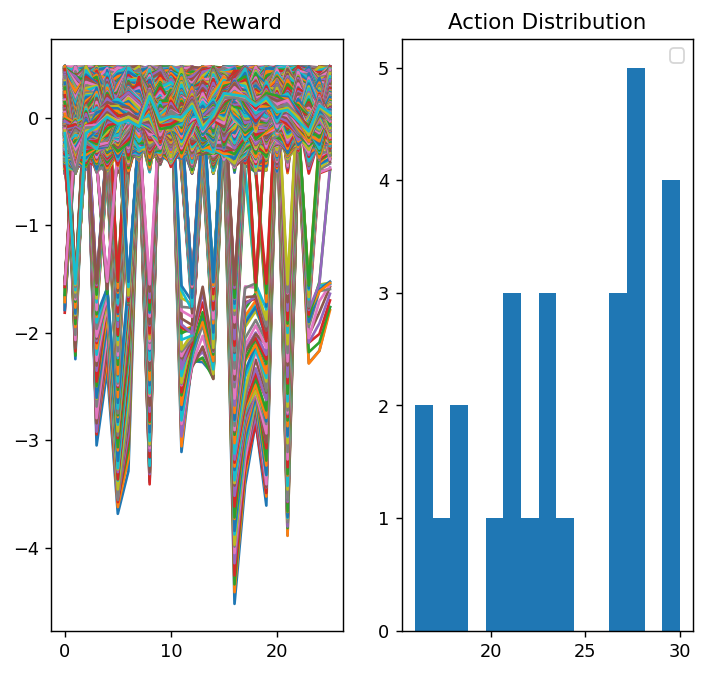

In [ ]:
# traning parameters visualization
def plot_training(reward, action):
    plt.figure(dpi=128,figsize=(10,6))

    # reward curve
    plt.subplot(131)
    plt.plot(reward)
    plt.title("Episode Reward")

    # action curve
    plt.subplot(132)
    plt.hist(action, bins=15)
    plt.title("Action Distribution")

    plt.legend()
    plt.show()

plot_training(results['reward'], results['actions'])

In [ ]:
# save model
torch.save({
    'actor_state_dict': best_model_actor,
    'critic_state_dict': best_model_critic,
}, path+'ac_model_test_hkt.pth')

In [ ]:
# define ac model tester class
class AC_Tester:
    def __init__(self, model_path, test_data, target_temp=22, hist_len=10):
        # set environment
        self.env = ACControlEnv(
            historical_temps=test_data,
            target_temp=target_temp,
            hist_len=hist_len
        )

        self.hist_len = hist_len

        #  load model
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.agent = Actor_Critic(self.env)
        self._load_model(model_path)

        # save test results
        self.results = {
            'episode_rewards': [],
            'temperature_traces': [],
            'action_sequences': [],
            'energy_consumptions': [],
            'outdoor_temperatures': []
        }

    def _load_model(self, model_path):
        checkpoint = torch.load(model_path, map_location=self.device)
        self.agent.actor.load_state_dict(checkpoint['actor_state_dict'])
        self.agent.critic.load_state_dict(checkpoint['critic_state_dict'])
        self.agent.actor.eval()
        self.agent.critic.eval()
        print(f"Load model sucessfully: {model_path}")

    def run_test(self, num_episodes=5, render_interval=10):
        for ep in tqdm(range(num_episodes), desc="Testing progress"):
            state = self.env.reset()
            done = False
            ep_data = {
                'rewards': [],
                'indoor_temps': [],
                'actions': [],
                'outdoor_temps': [],
                'energy': 0.0
            }

            while not done:
                # tensor conversion
                state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)

                # get action
                with torch.no_grad():
                    action, _, _ = self.agent.get_action(state_tensor)
                    action_temp = 16 + action  # convert to temperature

                # take action
                next_state, reward, done, _ = self.env.step(action)

                # keep record
                ep_data['rewards'].append(reward)
                ep_data['indoor_temps'].append(self.env.indoor_temp)
                ep_data['actions'].append(action_temp)
                ep_data['outdoor_temps'].append(self.env.outdoor_temp)

                # update state
                state = next_state

            # energy calculation
            energy = []
            _energy = self.env.ac_capacity * abs(np.array(ep_data['outdoor_temps'])
                                                    - np.array(ep_data['indoor_temps'])) * self.env.time_step
            energy.append(list(_energy))

            # save results
            self.results['episode_rewards'].append(sum(ep_data['rewards']))
            self.results['temperature_traces'].append(ep_data['indoor_temps'])
            self.results['action_sequences'].append(ep_data['actions'])
            self.results['energy_consumptions'].append(energy[0])
            self.results['outdoor_temperatures'].append(ep_data['outdoor_temps'])

            # visualize result
            if (ep+1) % render_interval == 0:
                self._visualize_episode(ep)

        print()
        print("finish testing!")
        self._generate_report()
        return self.results

    def predict(self):
        state = self.env.reset()
        done = False
        ep_data = {
            'rewards': [],
            'indoor_temps': [],
            'actions': [],
            'outdoor_temps': [],
            'energy': 0.0
        }

        while not done:
            # tensor conversion
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)

            # get action
            with torch.no_grad():
                action, _, _ = self.agent.get_action(state_tensor)
                action_temp = 16 + action  # convert to temperature

            # take action
            next_state, reward, done, _ = self.env.step(action)

            # keep record
            ep_data['rewards'].append(reward)
            ep_data['indoor_temps'].append(self.env.indoor_temp)
            ep_data['actions'].append(action_temp)
            ep_data['outdoor_temps'].append(self.env.outdoor_temp)

            # update state
            state = next_state

        # energy calculation
        energy = []
        _energy = self.env.ac_capacity * abs(np.array(ep_data['outdoor_temps'])
                                                 - np.array(ep_data['indoor_temps'])) * self.env.time_step
        energy.append(list(_energy))

        # save results
        self.results['episode_rewards'].append(sum(ep_data['rewards']))
        self.results['temperature_traces'].append(ep_data['indoor_temps'])
        self.results['action_sequences'].append(ep_data['actions'])
        self.results['energy_consumptions'].append(energy[0])
        self.results['outdoor_temperatures'].append(ep_data['outdoor_temps'])

        self._visualize_temp()
        self._visualize_actemp()

        self._generate_report()
        return self.results

    # visualize a single episode
    def _visualize_episode(self, ep_idx):
        fig, axs = plt.subplots(3, 1, figsize=(12, 9))

        # temperature
        axs[0].plot(self.results['temperature_traces'][ep_idx], label='Indoor Temperature', color='blue')
        axs[0].plot(self.results['outdoor_temperatures'][ep_idx], '--', label='Outdoor Temperature', color='orange')
        axs[0].axhline(self.env.target_temp, color='red', linestyle='--', label='Target Temperature')
        axs[0].set_title(f"Episode {ep_idx+1} - Temperature Control")
        axs[0].set_ylabel("Temperature (°C)")
        axs[0].legend()

        # set temperature
        axs[1].step(range(len(self.results['action_sequences'][ep_idx])),
                   self.results['action_sequences'][ep_idx],
                   where='post', color='green')
        axs[1].set_ylim(16, 30)
        axs[1].set_title("AC Temperature Setting")
        axs[1].set_ylabel("Temperature (°C)")

        # reward
        axs[2].plot(self.results['episode_rewards'][:ep_idx+1], marker='o')
        axs[2].set_title("Change of Reward")
        axs[2].set_xlabel("Episode")
        axs[2].set_ylabel("Reward")

        plt.tight_layout()
        plt.show()

    # visualize environmental temperature for predict method
    def _visualize_temp(self):
        plt.figure(dpi=128,figsize=(10,6))

        # temperature
        plt.plot(self.results['temperature_traces'][0], label='Indoor Temperature', color='blue')
        plt.plot(self.results['outdoor_temperatures'][0], '--', label='Outdoor Temperature', color='orange')
        plt.axhline(self.env.target_temp, color='red', linestyle='--', label='Target Temperature')
        plt.title('Indoor and Outdoor Temperature After setting Smart Air Conditioner',fontsize=20)
        plt.ylabel("Temperature (°C)")
        plt.legend()

        plt.tight_layout()
        plt.show()

    # visualize AC temperature setting for predict method
    def _visualize_actemp(self):
        plt.figure(dpi=128,figsize=(10,6))

        # AC temperature
        plt.step(range(len(self.results['action_sequences'][0])),
                   self.results['action_sequences'][0],
                   where='post', color='green')
        plt.ylim(16, 30)
        plt.title("AC Temperature Setting", fontsize=20)
        plt.ylabel("Temperature (°C)", fontsize=12)
        plt.xlabel("Day", fontsize=12)

        plt.tight_layout()
        plt.show()

    # analyze performance of the model
    def _generate_report(self):
        avg_reward = np.mean(self.results['episode_rewards'])
        avg_energy = np.mean(self.results['energy_consumptions'])/self.hist_len
        temp_errors = [np.mean(np.abs(np.array(trace) - self.env.target_temp))
                      for trace in self.results['temperature_traces']]

        print("\n" + "="*40)
        print(f"{' Test report ':=^40}")
        print(f"No of testing episodes: {len(self.results['episode_rewards'])}")
        print(f"Average episode reward: {avg_reward:.2f}")
        print(f"Average temperature error: {np.mean(temp_errors):.2f} ± {np.std(temp_errors):.2f} °C")
        print(f"Average energy consumption: {avg_energy:.2f} ± {np.std(self.results['energy_consumptions'])/self.hist_len:.2f} kW·h")
        print("="*40)

C:\Users\laich\AppData\Local\Temp\ipykernel_26768\3338140015.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=self.devic

Load model sucessfully: C:\test\HKA\ac_model_test_hkt.pth


Testing progress:   0%|          | 0/5 [00:00<?, ?it/s]

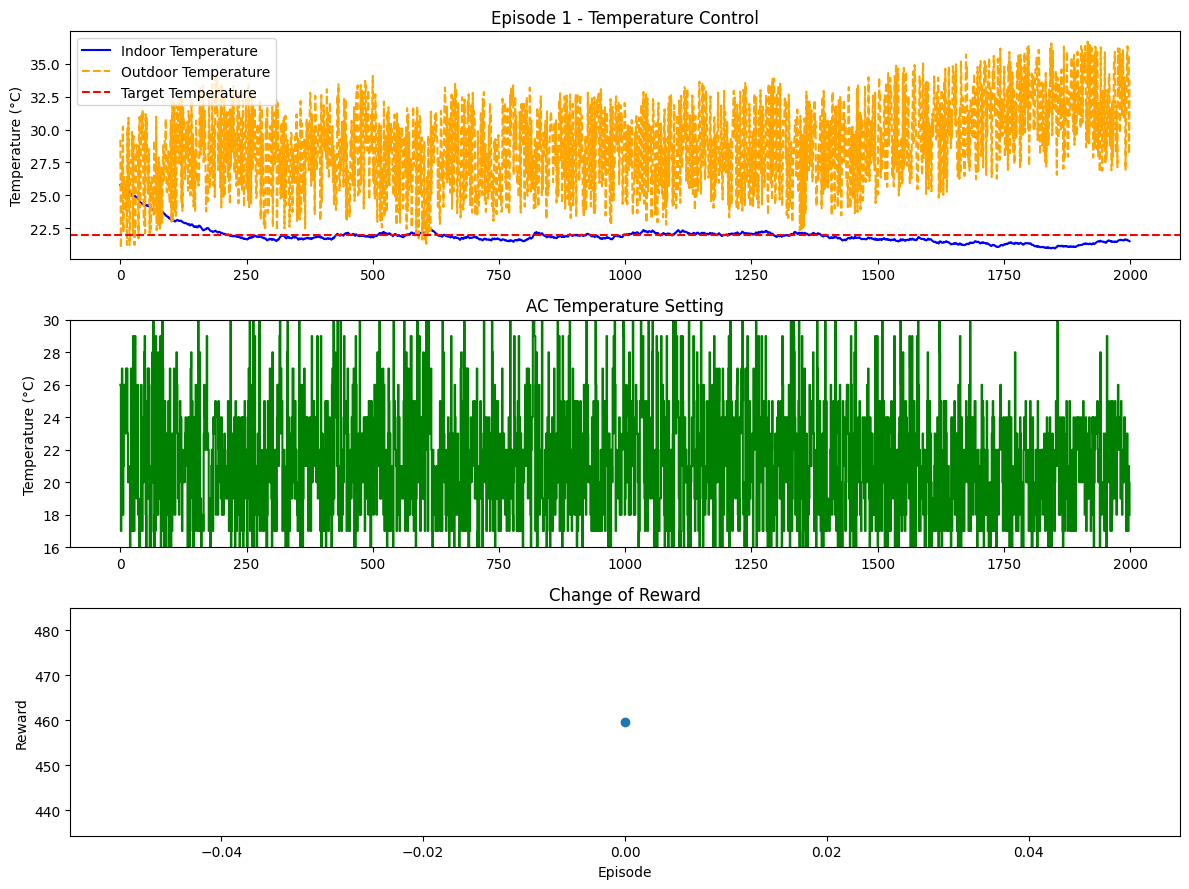

Testing progress:  20%|██        | 1/5 [00:02<00:11,  2.88s/it]

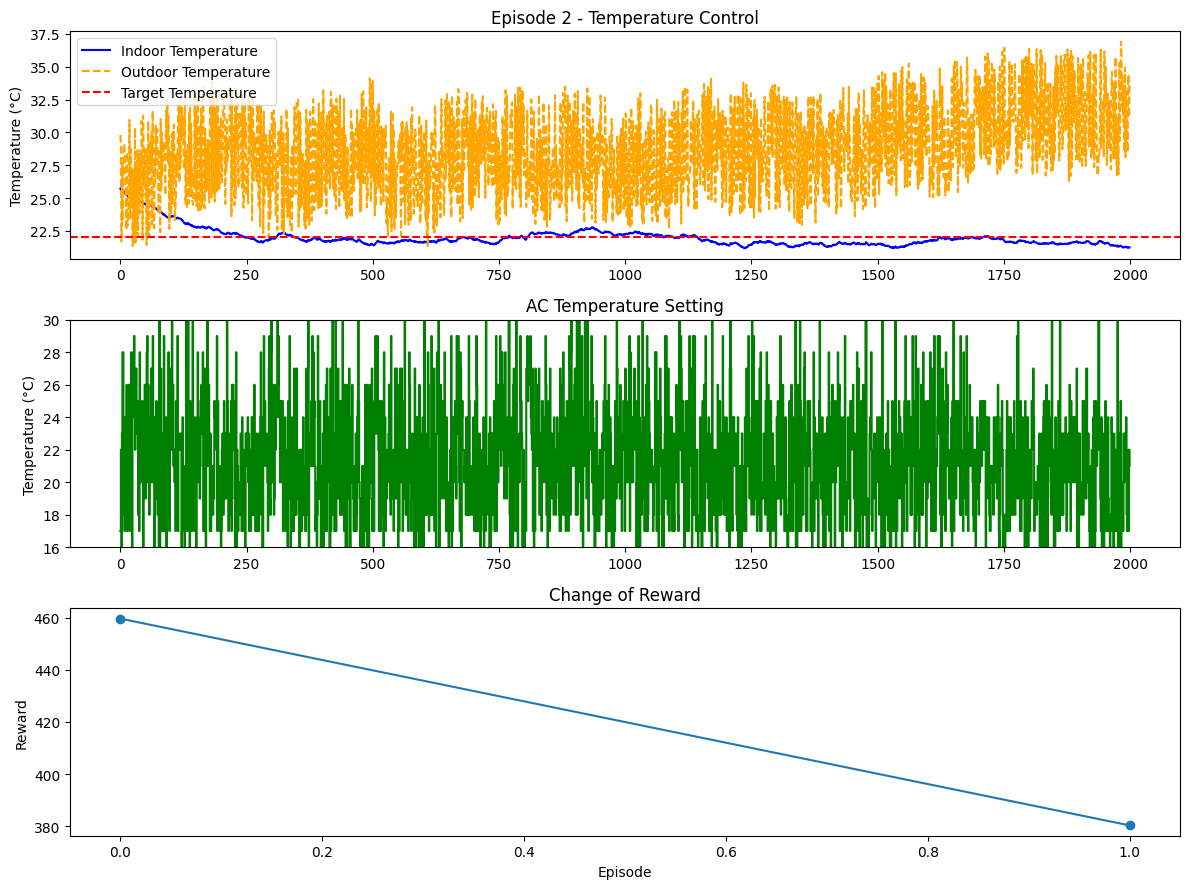

Testing progress:  40%|████      | 2/5 [00:05<00:08,  2.81s/it]

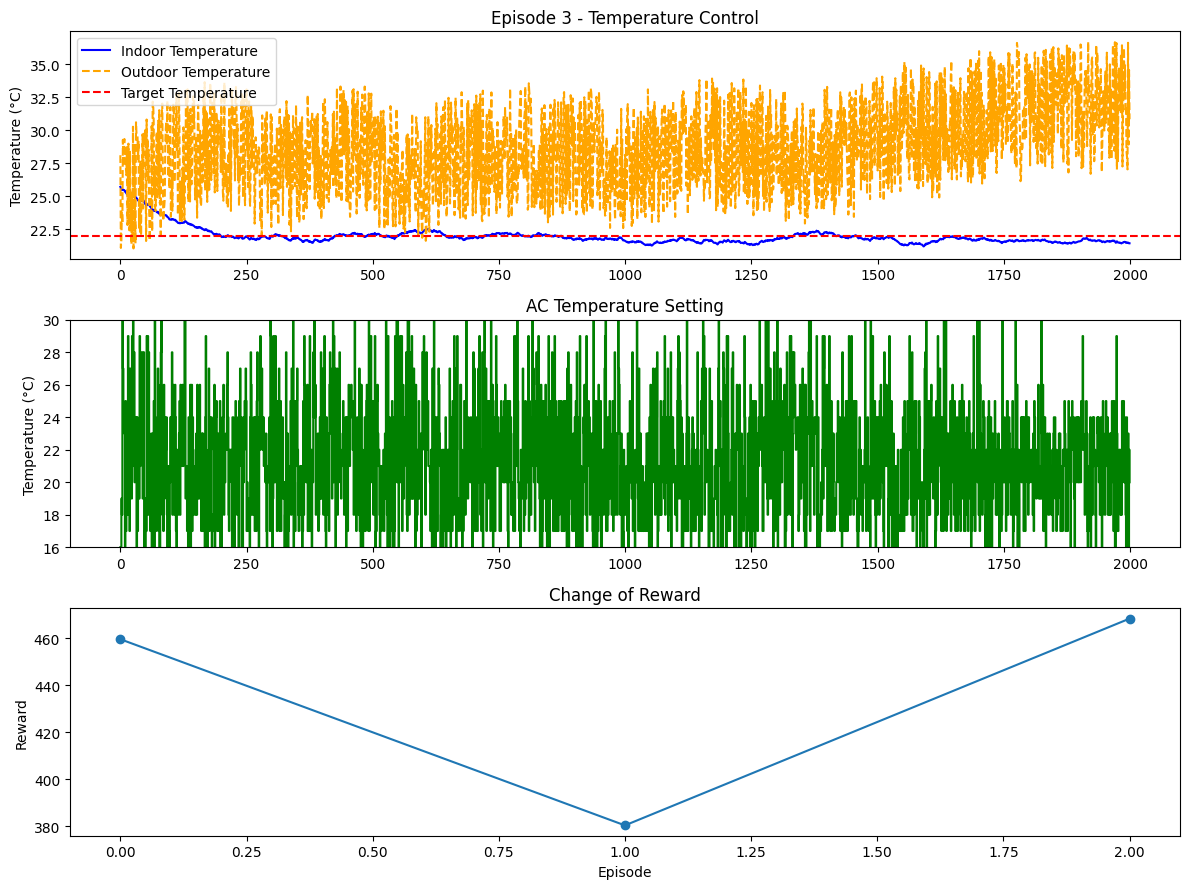

Testing progress:  60%|██████    | 3/5 [00:08<00:05,  2.83s/it]

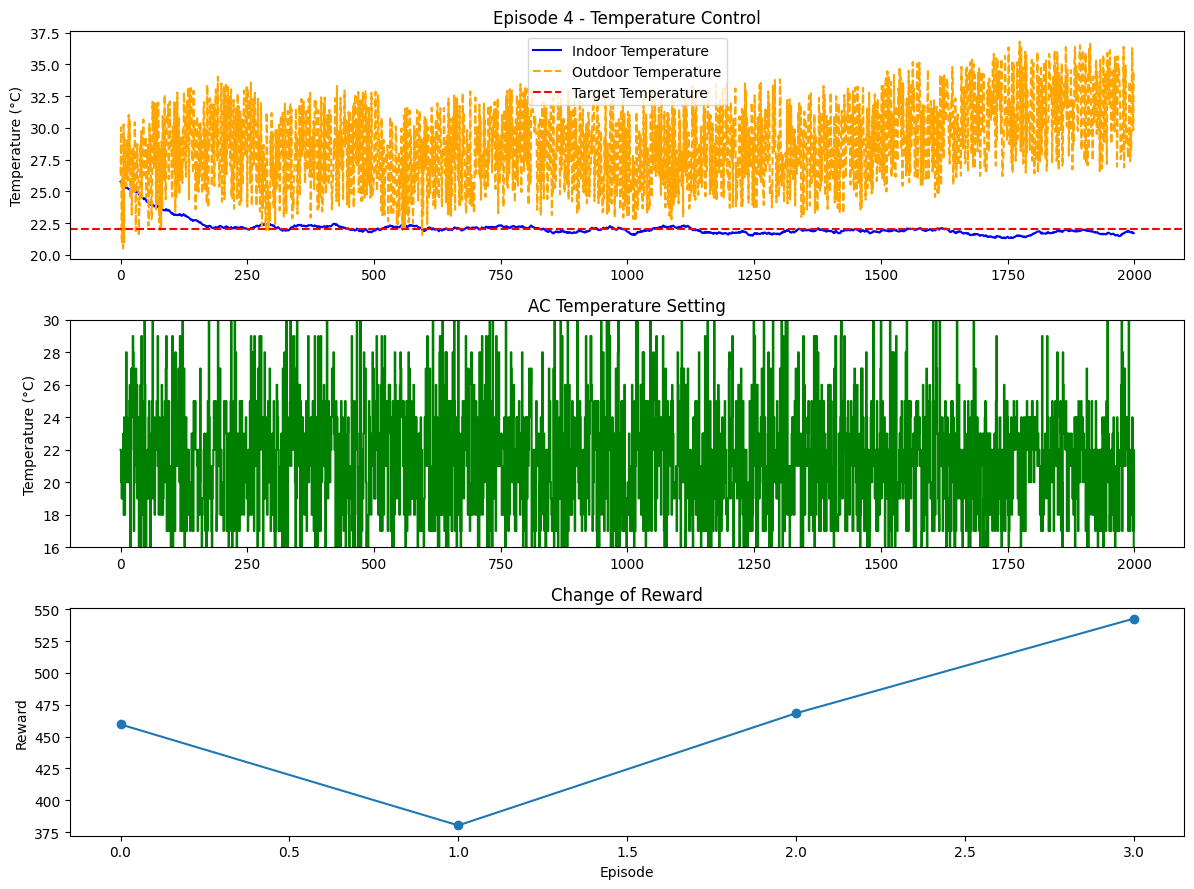

Testing progress:  80%|████████  | 4/5 [00:11<00:02,  2.86s/it]

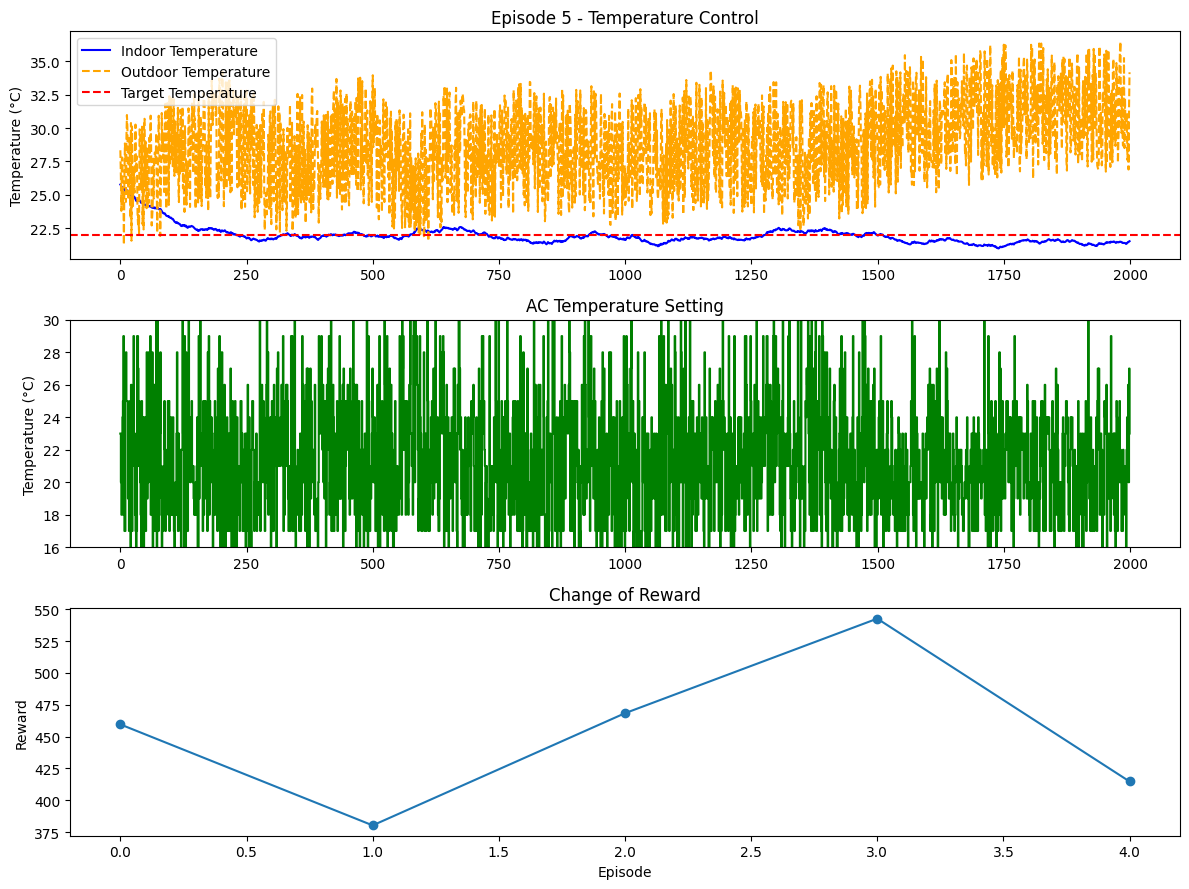

Testing progress: 100%|██████████| 5/5 [00:14<00:00,  2.82s/it]


finish testing!

============= Test report ==============
No of testing episodes: 5
Average episode reward: 453.16
Average temperature error: 0.41 ± 0.05 °C
Average energy consumption: 6.83 ± 3.37 kW·h


In [ ]:
# test model
if __name__ == "__main__":
    # initialize tester
    tester = AC_Tester(
        model_path=path+"ac_model_test_hkt.pth",
        test_data=test_temps,
        target_temp=22,
        hist_len=10
    )

    # run testing (5 episodes, and visualize each episode)
    results = tester.run_test(num_episodes=5, render_interval=1)

    # save test result
    with open("test_results.pkl", "wb") as f:
        pickle.dump(results, f)

C:\Users\laich\AppData\Local\Temp\ipykernel_26768\3338140015.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=self.devic

Load model sucessfully: C:\test\HKA\ac_model_test.pth


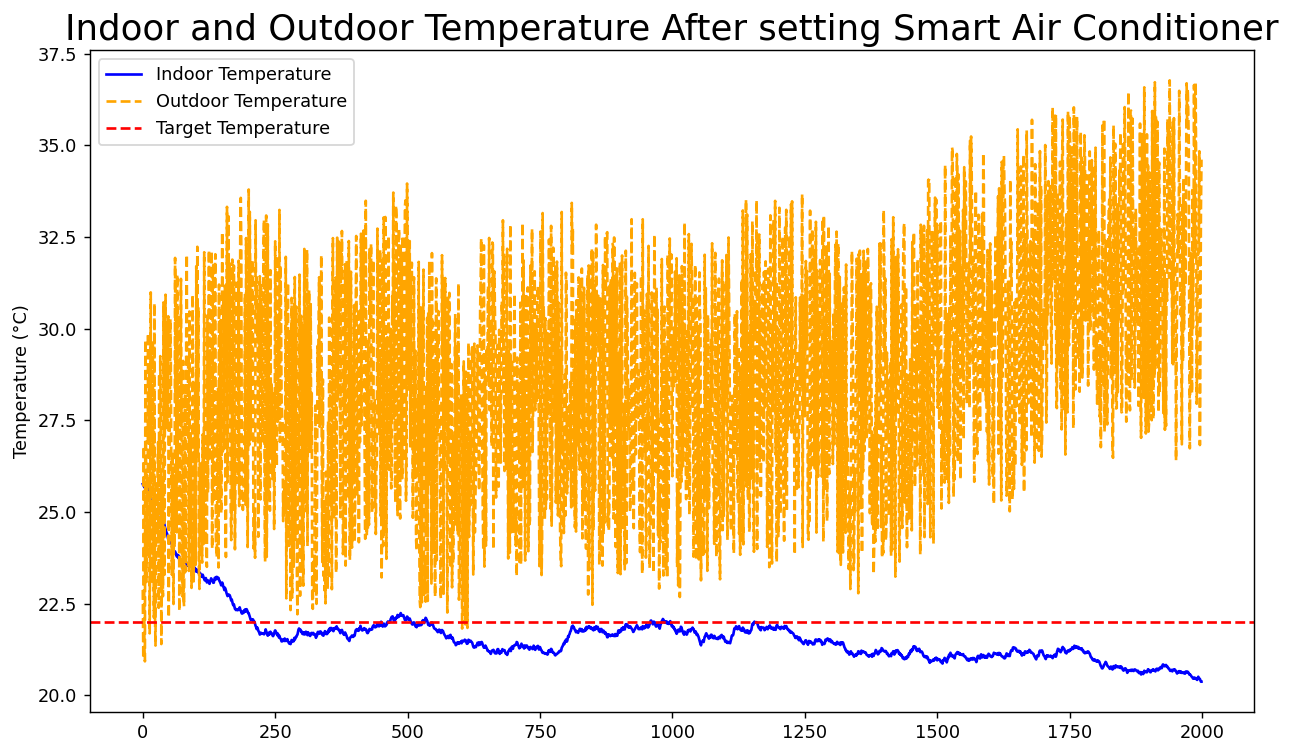

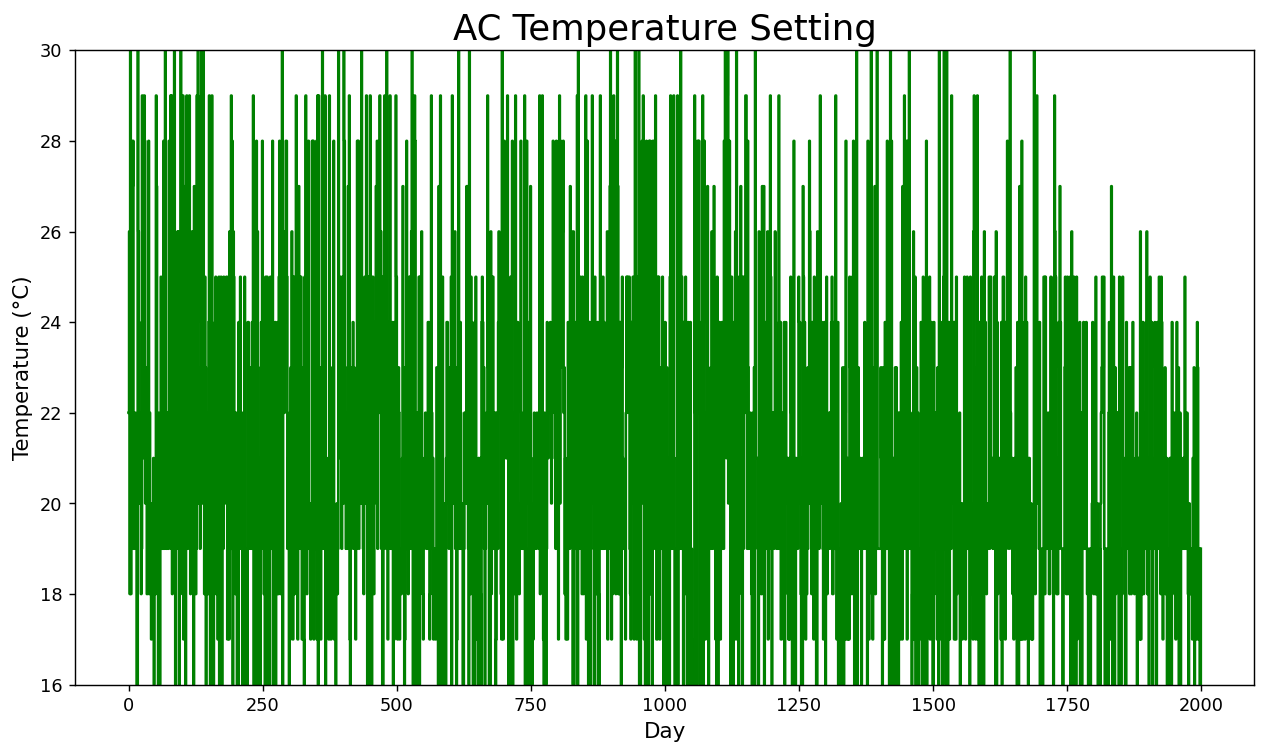


============= Test report ==============
No of testing episodes: 1
Average episode reward: 171.42
Average temperature error: 0.70 ± 0.00 °C
Average energy consumption: 7.11 ± 3.50 kW·h


In [ ]:
tester = AC_Tester(model_path=path+"ac_model_test.pth",test_data=test_temps,target_temp=22,hist_len=10)
results = tester.predict()

# **Test with the Provided Dataset From HKT Limited**

In [ ]:
# obtain data
hkt02 = pd.read_excel(path+"a002-1f-sr-tp01_timeseries.xlsx")

hkt02["ts"] = pd.to_datetime(hkt02["ts"].astype(float) / 1000.0, unit='s')

hkt02copy = pd.read_excel(path+"a002-1f-sr-tp01_timeseries.xlsx")

hkt02copy["ts"] = pd.to_datetime(hkt02copy["ts"].astype(float) / 1000.0, unit='s')

hkt02.set_index('ts', inplace=True)

test_hkt02 = hkt02.resample('H').first()

test_hkt02["temperature"].fillna(method="ffill", inplace=True)

test02_temps = np.array(test_hkt02["temperature"])
test02_temps = test02_temps[5000:7000]

C:\Users\laich\AppData\Local\Temp\ipykernel_26768\742082969.py:12: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  test_hkt02 = hkt02.resample('H').first()
C:\Users\laich\AppData\Local\Temp\ipykernel_26768\742082969.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_hkt02["temperature"].fillna(method="ffill", inplace=True)
C:\Users\laich\AppData\Local\Temp\ipykernel_26768\742082969.py:14: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a futu

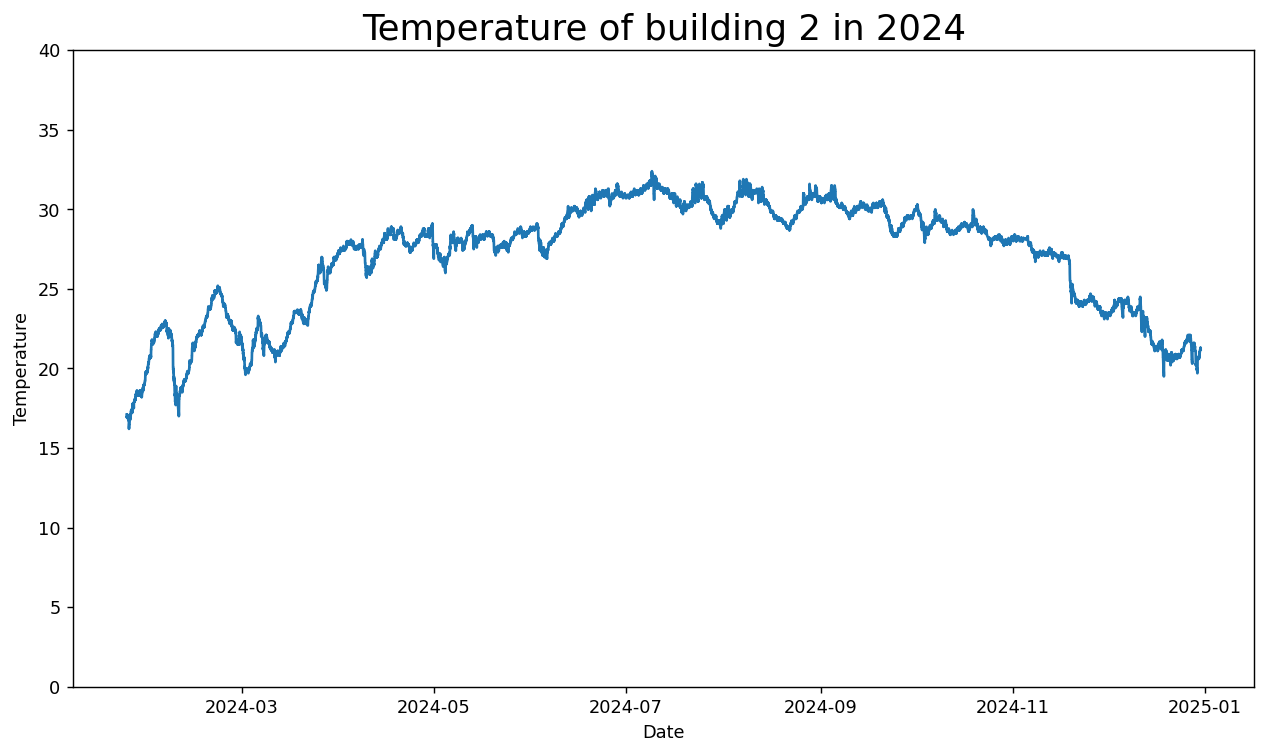

In [ ]:
# visualize testing data
fig = plt.figure(dpi=128,figsize=(10,6))
dates = hkt02copy["ts"]
temps = hkt02["temperature"]
plt.title('Temperature of building 2 in 2024',fontsize=20)
L1,=plt.plot(dates, temps, label='Wind Speed')
y_ticks = np.linspace(0, 40, 9)
plt.yticks(y_ticks)
#plt.legend(handles=[L1],labels=['Wind Speed'], loc='best')
plt.xlabel('Date', fontsize=10)
plt.ylabel('Temperature', fontsize=10)
plt.tight_layout()
plt.tick_params(axis='both',which='major',labelsize=10)

C:\Users\laich\AppData\Local\Temp\ipykernel_26768\3338140015.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=self.devic

Load model sucessfully: C:\test\HKA\ac_model_test.pth


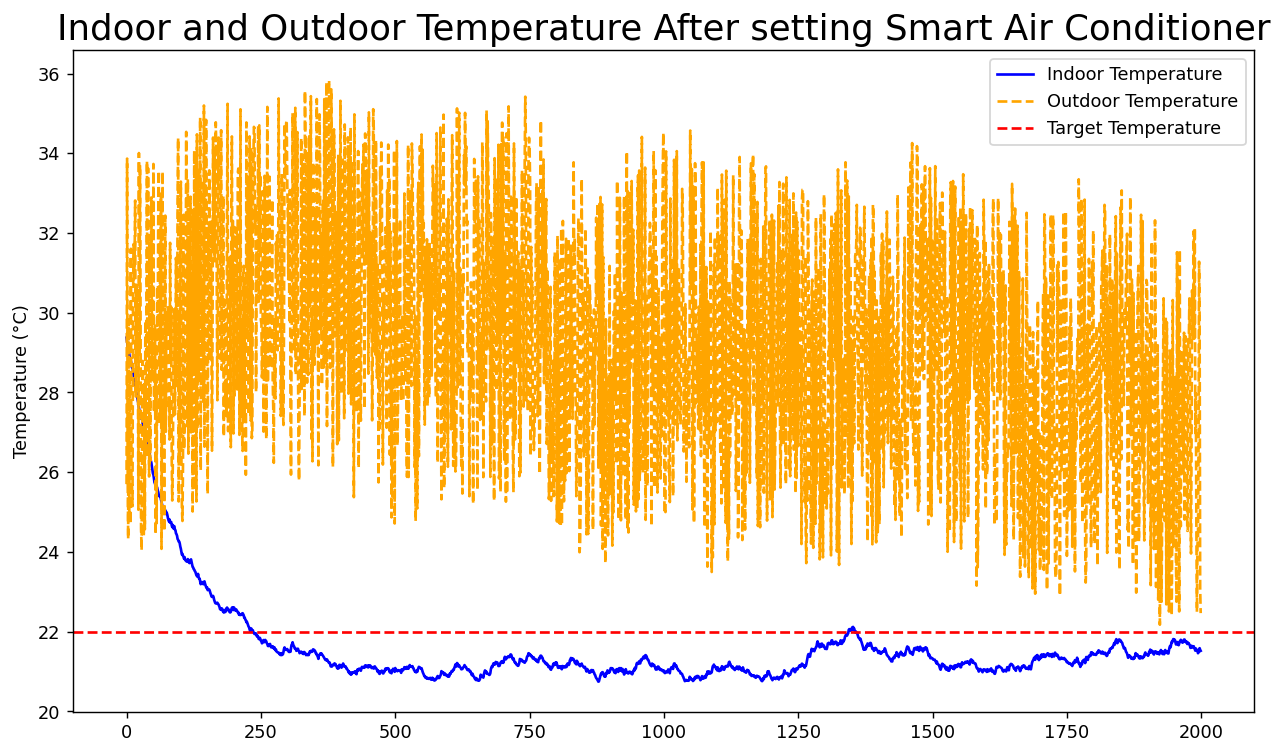

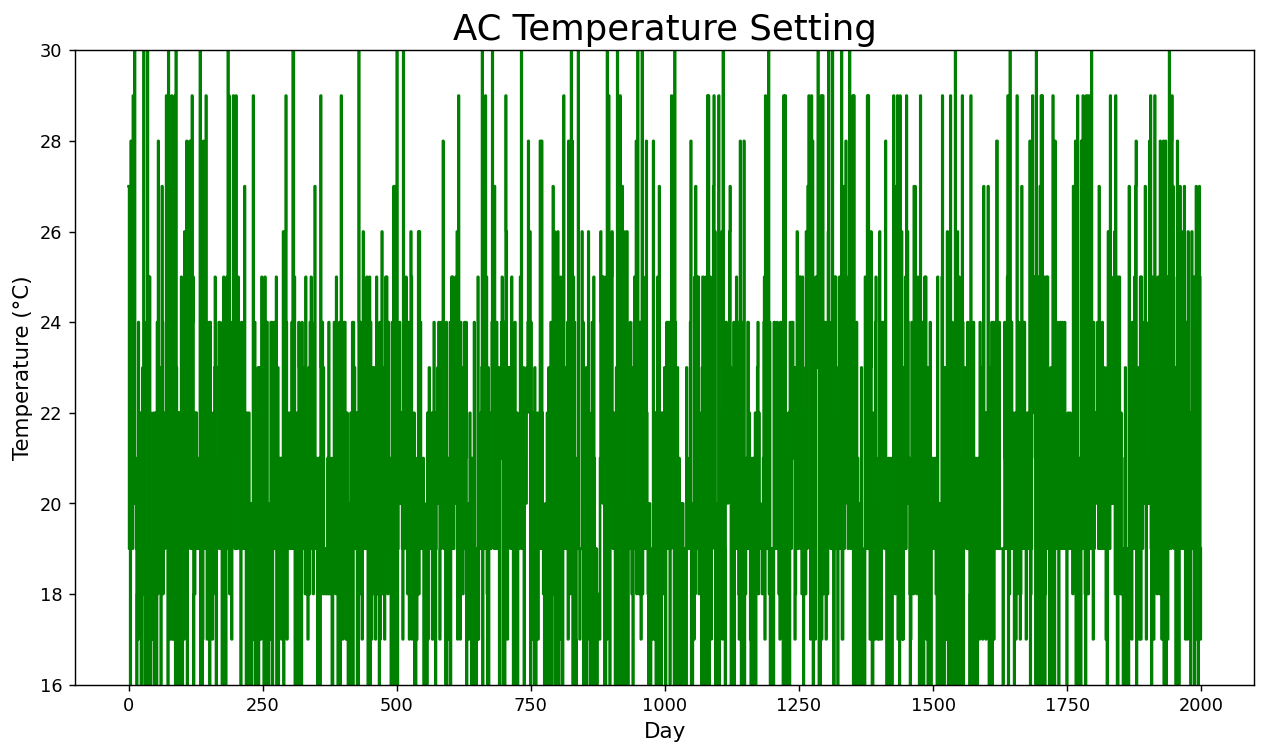


============= Test report ==============
No of testing episodes: 1
Average episode reward: -202.47
Average temperature error: 0.94 ± 0.00 °C
Average energy consumption: 7.63 ± 3.12 kW·h


In [ ]:
# test with the provided dataset
tester = AC_Tester(model_path=path+"ac_model_test.pth",test_data=test02_temps,target_temp=22,hist_len=10)
results = tester.predict()

# **Real Life Simulation**

In [ ]:
# create mock sensor data
historical_data = []
for i in range(10):
    day = datetime(2023,7,20) - timedelta(days=10-i)
    # obtain indoor and outdoor temperature
    indoor = 30 + np.random.uniform(-2,2)
    outdoor = 28.3 + i*0.5  # simulate temperature increase
    historical_data.append([indoor, outdoor])

raw_data = np.array(historical_data)

In [ ]:
# obtain recommended ac temperature with RBC AC
AC = AC_Temp_Control()
print(f"Current Indoor Temperature: {raw_data[-1][0]:.3f}°C\tOutdoor Temperature: {raw_data[-1][1]}°C")
print(f"Recommend AC Temperature: {AC.temp_set(raw_data[-1][1])}°C")
print(f"New Indoor Temperature: {indoor_temp_change(AC.temp_set(raw_data[-1][1]), raw_data[-1][0], raw_data[-1][0]):.3f}°C")
print(f"Energy Consumption: {energy_consume(AC.temp_set(raw_data[-1][1]), raw_data[-1][0], raw_data[-1][0]):.3f}kW")

Current Indoor Temperature: 29.787°C	Outdoor Temperature: 32.8°C
Recommend AC Temperature: 20°C
New Indoor Temperature: 29.689°C
Energy Consumption: 291.514kWh


In [ ]:
class AC_output:
    def __init__(self, model_path, hist_len=10, feature_dim = 2):
        self.hist_len = hist_len
        self.feature_dim = feature_dim
        self.actor = Actor(action_dim = 15)
        self.critic = Critic()

        checkpoint = torch.load(model_path)
        self.actor.load_state_dict(checkpoint['actor_state_dict'])
        self.critic.load_state_dict(checkpoint['critic_state_dict'])
        self.actor.eval()

    # predict the AC temperature setting
    def predict(self, raw_data):
        raw_data = self._get_full_data(raw_data)

        input_tensor = torch.FloatTensor(raw_data).unsqueeze(0)

        with torch.no_grad():
            action_probs = self.actor(input_tensor)
            action = torch.argmax(action_probs).item()

        return 16 + action

    # fill the dataset if the data is shorter than the required length
    def _get_full_data(self, raw_data):
        while raw_data.shape[0] < self.hist_len:
            raw_data = np.concatenate((raw_data[0].reshape(1, -1), raw_data[:]), axis=0)

        return raw_data[-self.hist_len:]


In [ ]:
# obtain recommended ac temperature with AC-MPC
ACMPC = AC_output(model_path=path+"ac_model_test.pth")
print(f"Current Indoor Temperature: {raw_data[-1][0]:.3f}°C\tOutdoor Temperature: {raw_data[-1][1]}°C")
print(f"Recommend AC Temperature: {ACMPC.predict(raw_data)}°C")
print(f"New Indoor Temperature: {indoor_temp_change(ACMPC.predict(raw_data), raw_data[-1][0], raw_data[-1][0]):.3f}°C")
print(f"Energy Consumption: {energy_consume(ACMPC.predict(raw_data), raw_data[-1][0], raw_data[-1][0]):.3f}kW")

Current Indoor Temperature: 29.787°C	Outdoor Temperature: 32.8°C
Recommend AC Temperature: 22°C
New Indoor Temperature: 29.709°C
Energy Consumption: 231.941kWh


C:\Users\laich\AppData\Local\Temp\ipykernel_20996\3556774700.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


# **Combination of Weather Prediction and AC-MPC**

In [ ]:
# load trained model from depository
lstm_model = LSTMModel() # from cell 33

# load best scored
best_model_weights_path = os.path.join(path, 'best_model_weights.pth')
lstm_model.load_state_dict(torch.load(best_model_weights_path))

# evaluation
lstm_model.eval()

# load other parameters
params_path = os.path.join(path, 'training_params.pth')
params = torch.load(params_path)
best_score = params['best_score']
best_train_preds = params['best_train_preds']
best_test_preds = params['best_test_preds']
epochs = params['epochs']

# process test data
future_steps = 10
test_ = pd.read_csv(path+"TEST_"+place+"_DATASET_.csv")
test_ = test_.values.astype("float32")
x_test = test_[-future_steps:,1:]
y_test = x_test[:,-1]
scaler = MinMaxScaler()
x_test = scaler.fit_transform(x_test)

# make prediction
pred_temp = predict_future(lstm_model, x_test, future_steps)  # from cell 40

# undo scaling
predicted_temps = scaler.inverse_transform(np.array(pred_temp))
print(f"Temperature predictions of coming {future_steps} days:", predicted_temps[:,-1])

hkt02 = pd.read_excel("C:\\test\\dataset_hkt\\hkt\\a002-1f-sr-tp01_timeseries.xlsx")
hkt02temps = np.array(hkt02["temperature"].astype(float))
hkt02temps = hkt02temps[10:20]
hkt02temps = hkt02temps[:,None]
ptemp = predicted_temps[:,-1]
ptemp = ptemp[:,None]
predicted_temps = np.concatenate((hkt02temps, ptemp), axis=1)

# predict action of Air Conditioner
ACMPC = AC_output(model_path=path+"ac_model_test.pth")
print(f"Current Indoor Temperature: {predicted_temps[-1][0]:.3f}°C\tOutdoor Temperature: {predicted_temps[-1][1]}°C")
print(f"Recommend AC Temperature: {ACMPC.predict(predicted_temps)}°C")
print(f"New Indoor Temperature: {indoor_temp_change(ACMPC.predict(predicted_temps), predicted_temps[-1][0], predicted_temps[-1][0]):.3f}°C")
print(f"Energy Consumption: {energy_consume(ACMPC.predict(predicted_temps), predicted_temps[-1][0], predicted_temps[-1][0]):.3f}kWh")


C:\Users\laich\AppData\Local\Temp\ipykernel_26768\3262023245.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  lstm_model.load_state_dict(torch.load(best_model_weights_pat

Temperature predictions of coming 10 days: [20.218672 20.836864 21.17171  21.328287 21.40562  21.461216 21.530796
 21.623268 21.724028 21.826805]
Current Indoor Temperature: 17.000°C	Outdoor Temperature: 21.826805114746094°C
Recommend AC Temperature: 19°C
New Indoor Temperature: 17.020°C
Energy Consumption: 34.000kWh


C:\Users\laich\AppData\Local\Temp\ipykernel_26768\3556774700.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)
